## Project 4. Functional connectivity analysis during motor imagery using fMRI

#### Installing Packages

In [1]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
from nilearn import input_data, plotting, image
import os


#### First we had to extract the files from the compressed (.tar.bz2) extension

## PART I - Compute Average Functional Connectomes

### 1. Load the files

We need to load the data (the NIFTI files for each image), the NIFTI of the atlas and the Atlas Label Locations

The current version of the code only loads one image belonging to subject 12, first scenario.

In [2]:
# Define paths (adjust these to your data location)
data_path = 'Project4/sub-13'
atlas_path = 'Schaefer_100parcels_7Networks/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz'
lut_path = 'Schaefer_100parcels_7Networks/Schaefer2018_100Parcels_7Networks_order.lut'
# Load a single subject's preprocessed fMRI data
fmri_path = os.path.join(data_path, 'sub-13_ses-inside1_task-grazMI_run-01_filtered_func_data2standard.nii.gz')
fmri_img = nib.load(fmri_path)

# Load the atlas
atlas_img = nib.load(atlas_path)

### Plotting the Atlas to see the regions

The image shows teh distribution of the 100 regions of the Schaefer Atlas

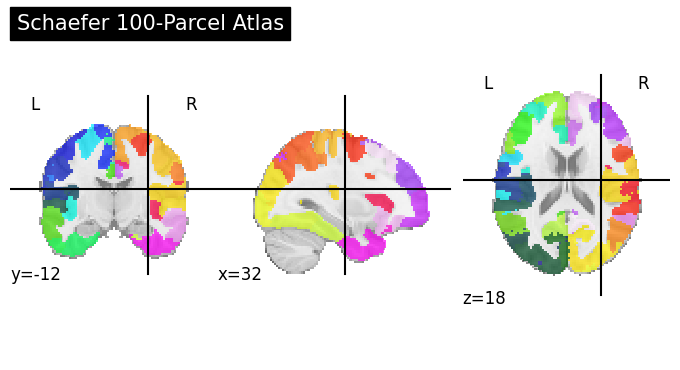

In [3]:
# Plot the atlas on a standard template
display = plotting.plot_roi(atlas_img, title="Schaefer 100-Parcel Atlas")
plt.savefig('atlas_visualization.png')
plt.show()

In [4]:
# Visualize the atlas in 3D
view = plotting.view_img(atlas_img, title="Schaefer 100-Parcel Atlas (3D View)")
view.open_in_browser()

/Users/joaomata/Desktop/NeuroProject/.venv/lib/python3.13/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


### Name all the 100 regions

Get the names from the .LUT file

In [5]:
import pandas as pd

def load_region_names(lut_path):
    try:
        # Load LUT file assuming space-separated values
        lut_df = pd.read_csv(lut_path, sep=r'\s+', header=None, names=['ID', 'R', 'G', 'B', 'Region'])
        
        # Ensure we have at least 100 regions
        if len(lut_df) < 100:
            raise ValueError(f"LUT file  contains only {len(lut_df)} regions, expected 100.")

        return lut_df['Region'].tolist()  # Extract and return region names
    
    except Exception as e:
        print(f"Error loading LUT file: {e}")
        return [f"Region_{i+1}" for i in range(100)]  # Fallback default names

# Example usage:
region_names = load_region_names(lut_path)
print(f"Loaded {len(region_names)} regions: {region_names[:5]}")


Loaded 100 regions: ['7Networks_LH_Vis_1', '7Networks_LH_Vis_2', '7Networks_LH_Vis_3', '7Networks_LH_Vis_4', '7Networks_LH_Vis_5']


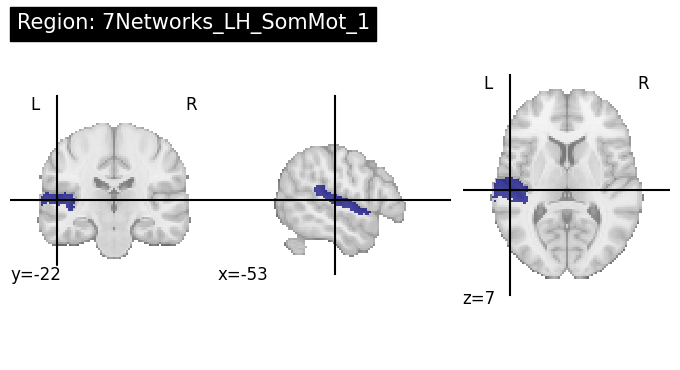

In [6]:
# Plot a specific region (e.g., region 10)
region_img = image.math_img('img == 10', img=atlas_img)
display = plotting.plot_roi(region_img, title=f"Region: {region_names[9]}")
plt.savefig('Images/single_region_visualization.png')
plt.show()

### Yeo's 7 Networks for reference

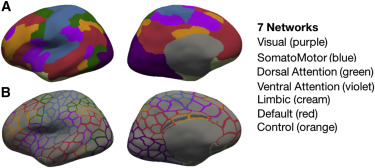

In [7]:

# Create a masker to extract time series from each region
masker = input_data.NiftiLabelsMasker(
    labels_img=atlas_img,
    standardize=True,  # Z-score normalization
    memory='nilearn_cache',  # Cache results
    verbose=1)

# Extract time series
time_series = masker.fit_transform(fmri_img)
print(f"Time series shape: {time_series.shape}")

[NiftiLabelsMasker.wrapped] loading data from Nifti1Image('Schaefer_100parcels_7Networks/Schaefer2018_100Parcels_7Networks_order_FSLMNI152_2mm.nii.gz')
________________________________________________________________________________
[Memory] Calling nilearn.maskers.base_masker._filter_and_extract...
_filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x13c4e1010>, <nilearn.maskers.nifti_labels_masker._ExtractionFunctor object at 0x147eda7b0>, { 'background_label': 0,
  'clean_kwargs': {},
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'high_variance_confounds': False,
  'keep_masked_labels': True,
  'labels': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x13c41f390>,
  'low_pass': None,
  'mask_img': None,
  'reports': True,
  'smoothing_fwhm': None,
  'standardize': True,
  'standardize_confounds': True,
  'strategy': 'mean',
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, sample_mask=None, dtype=None, memory=Memory(lo

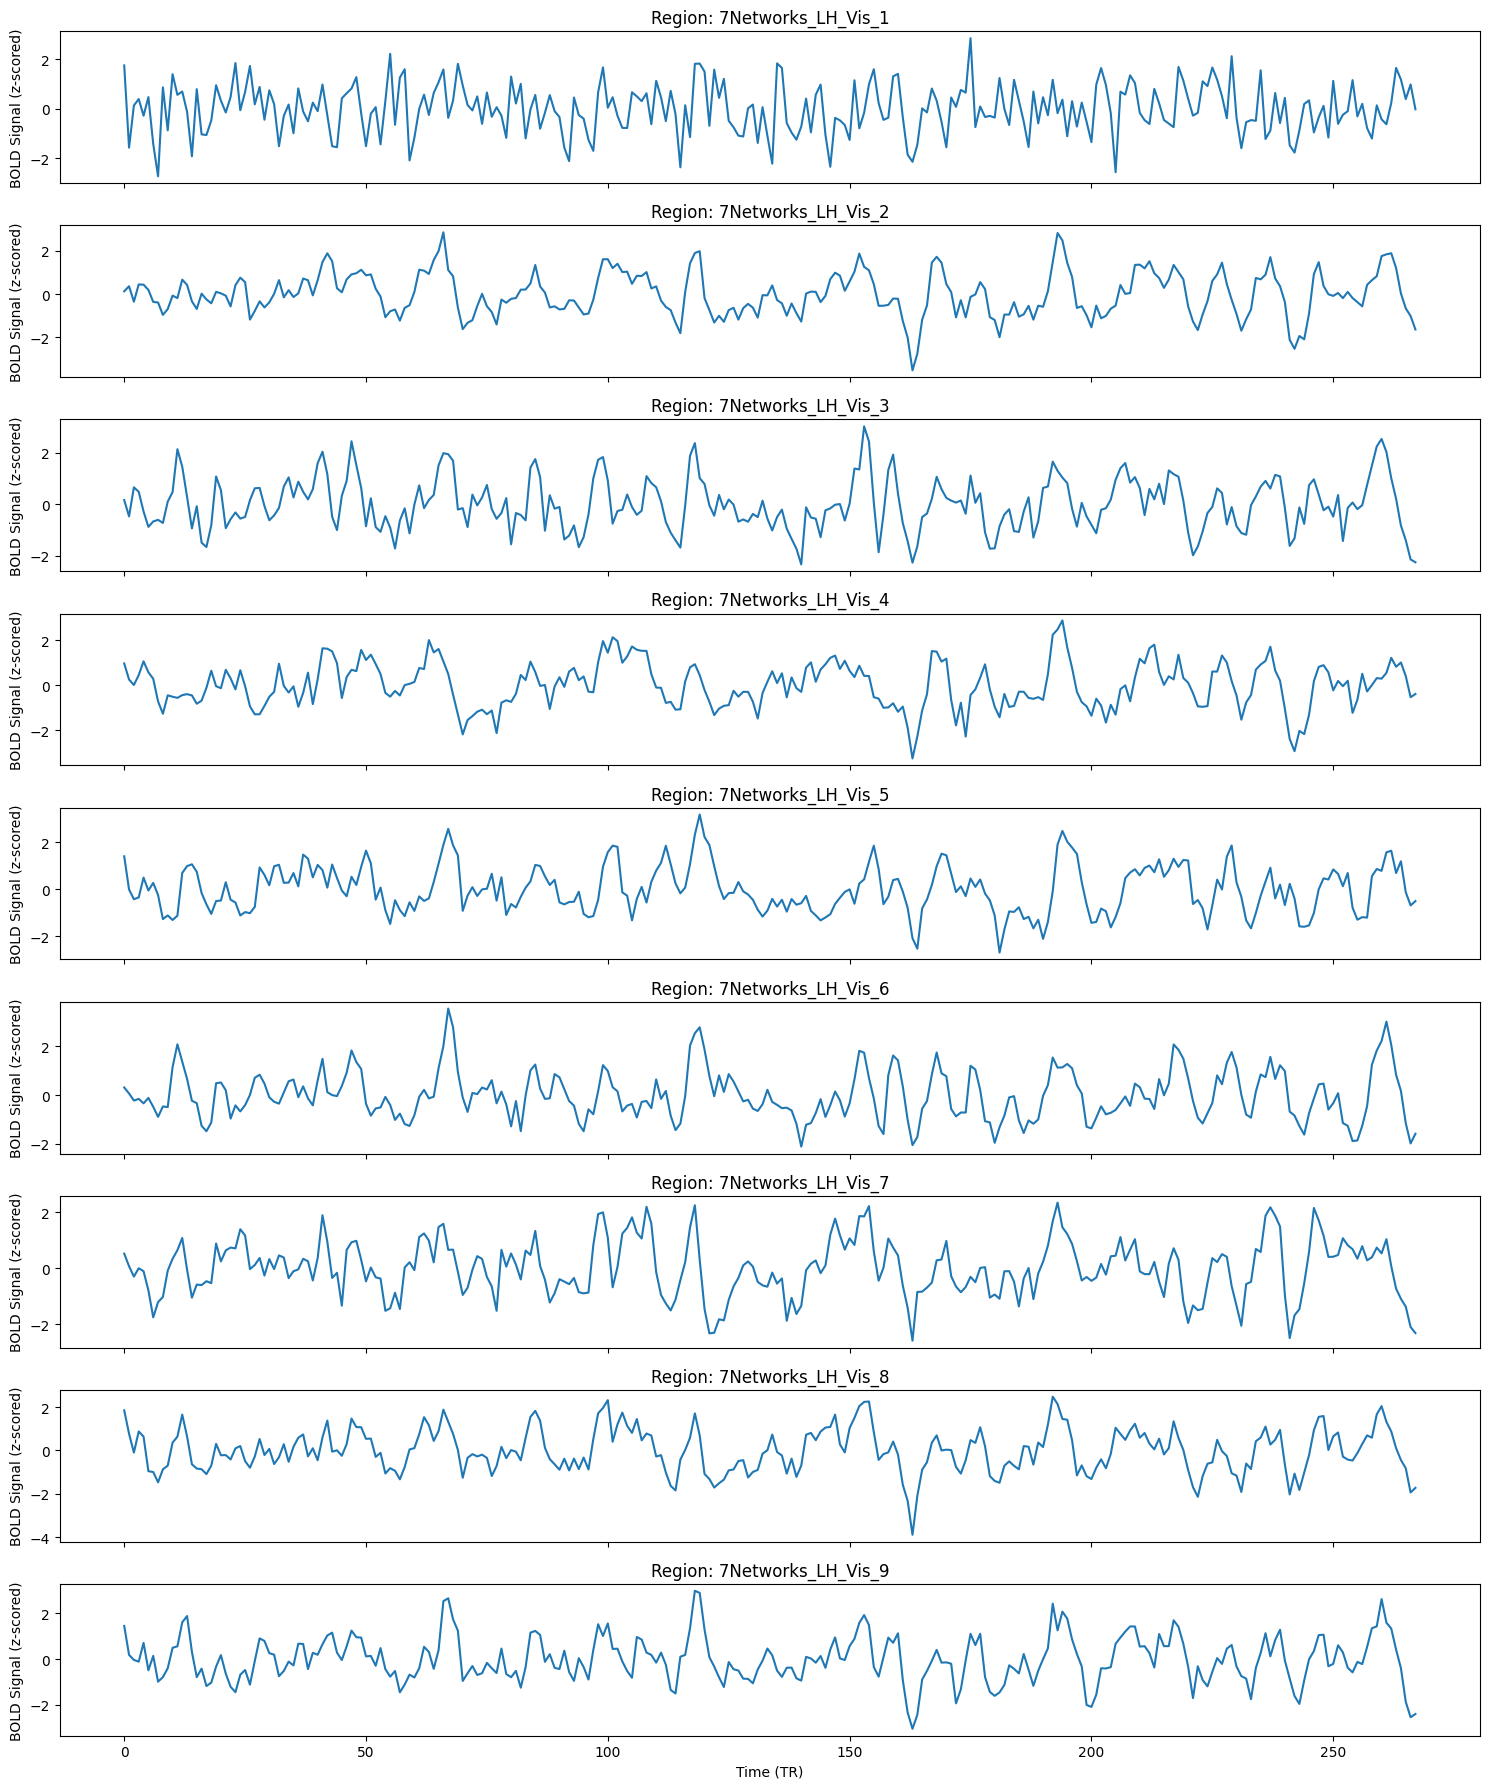

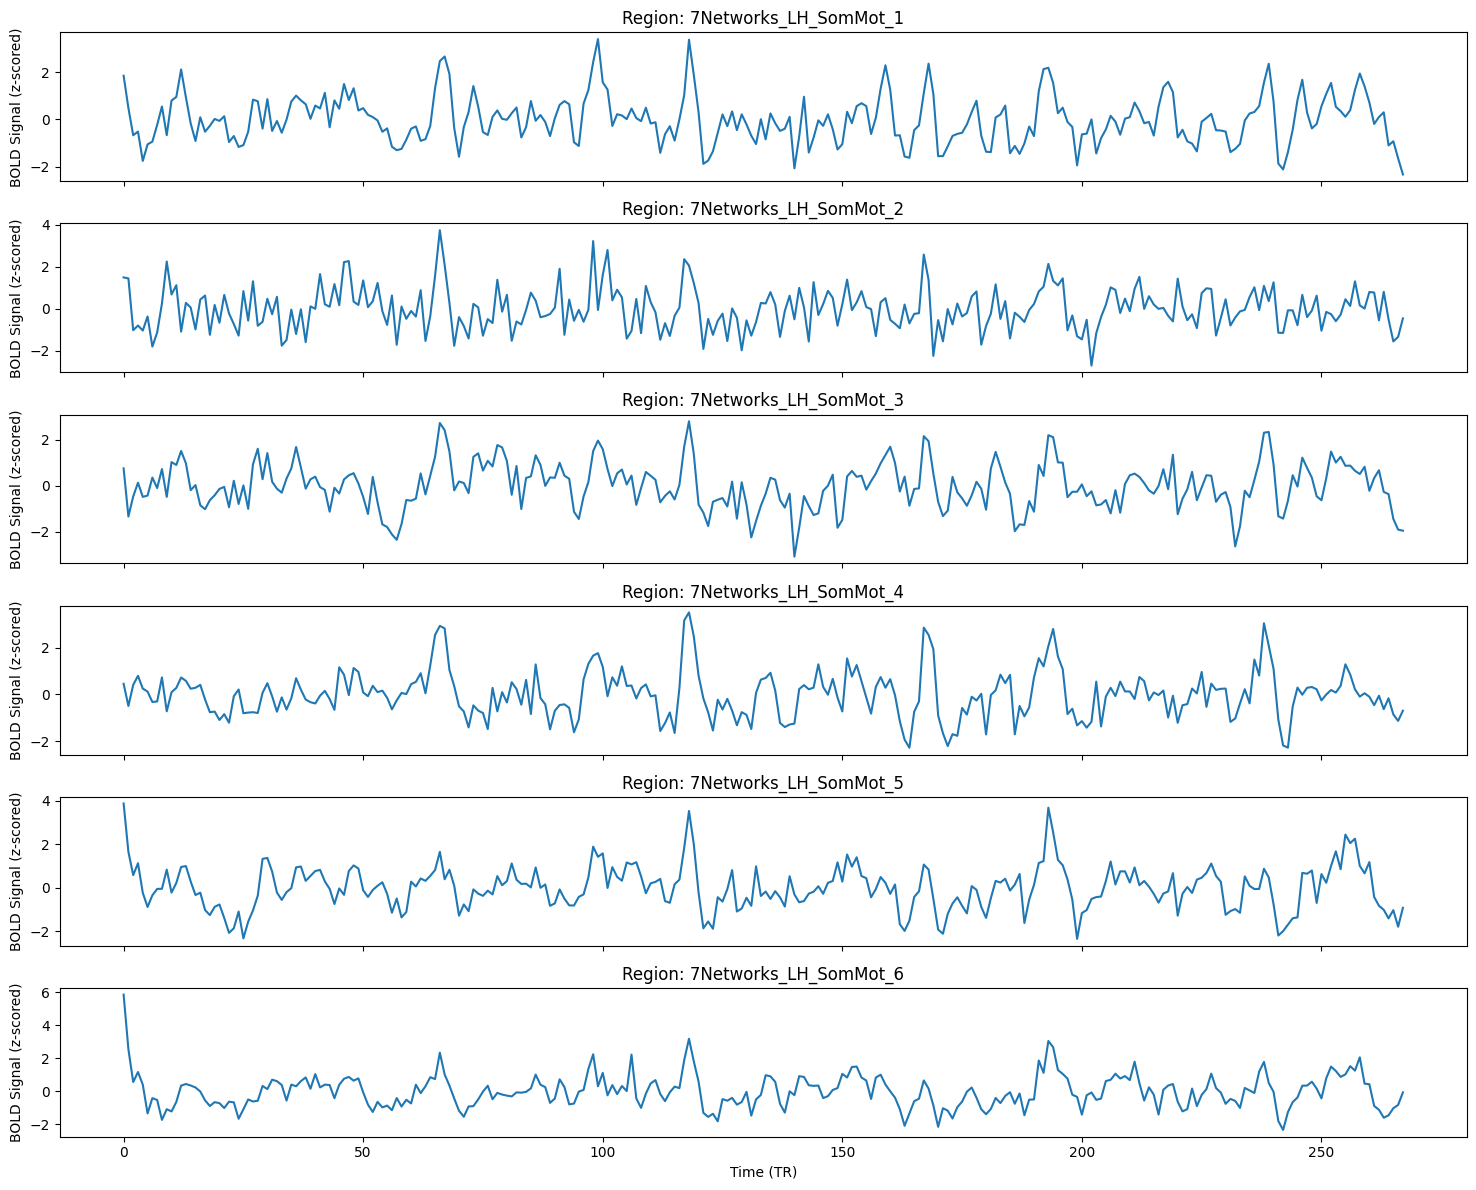

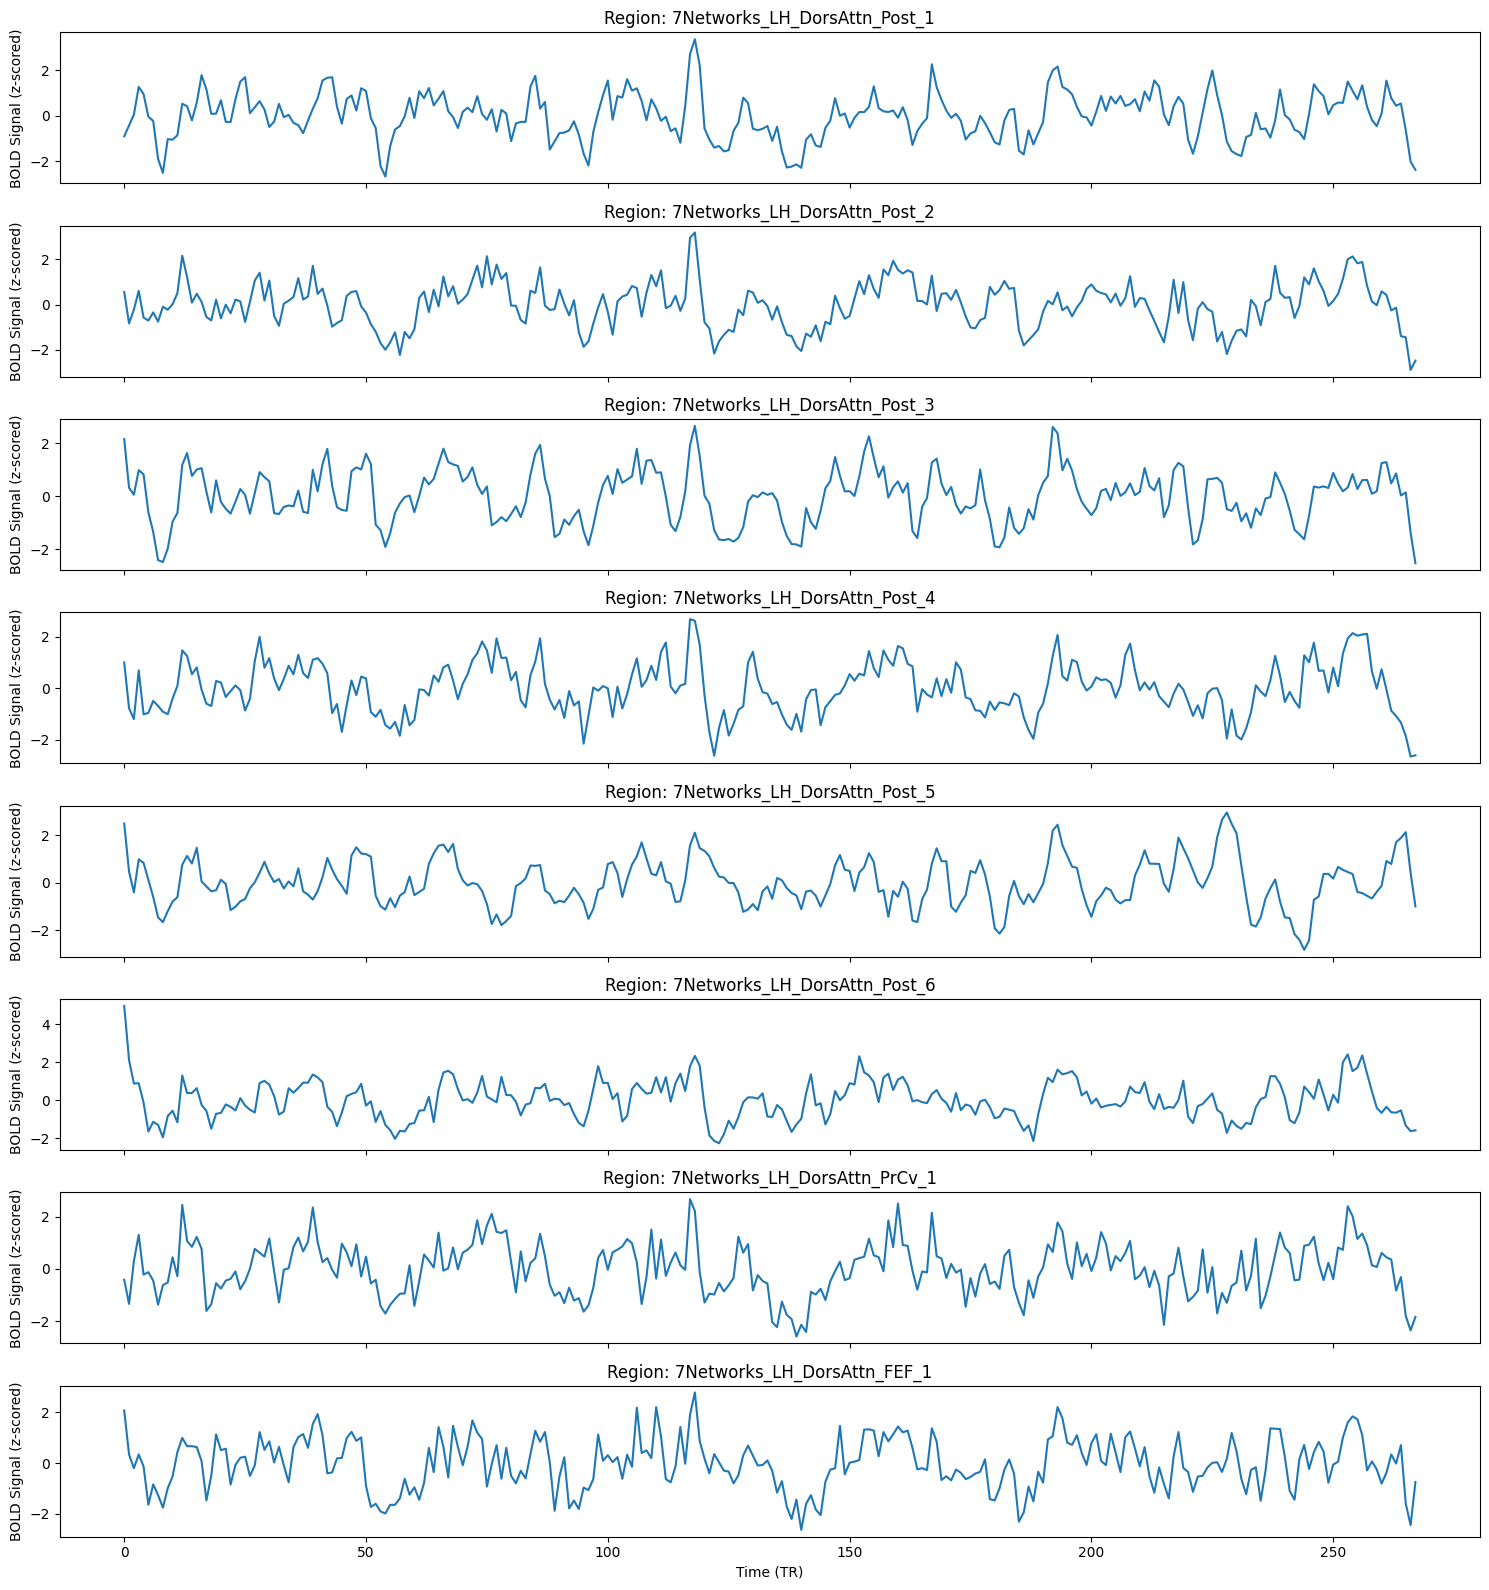

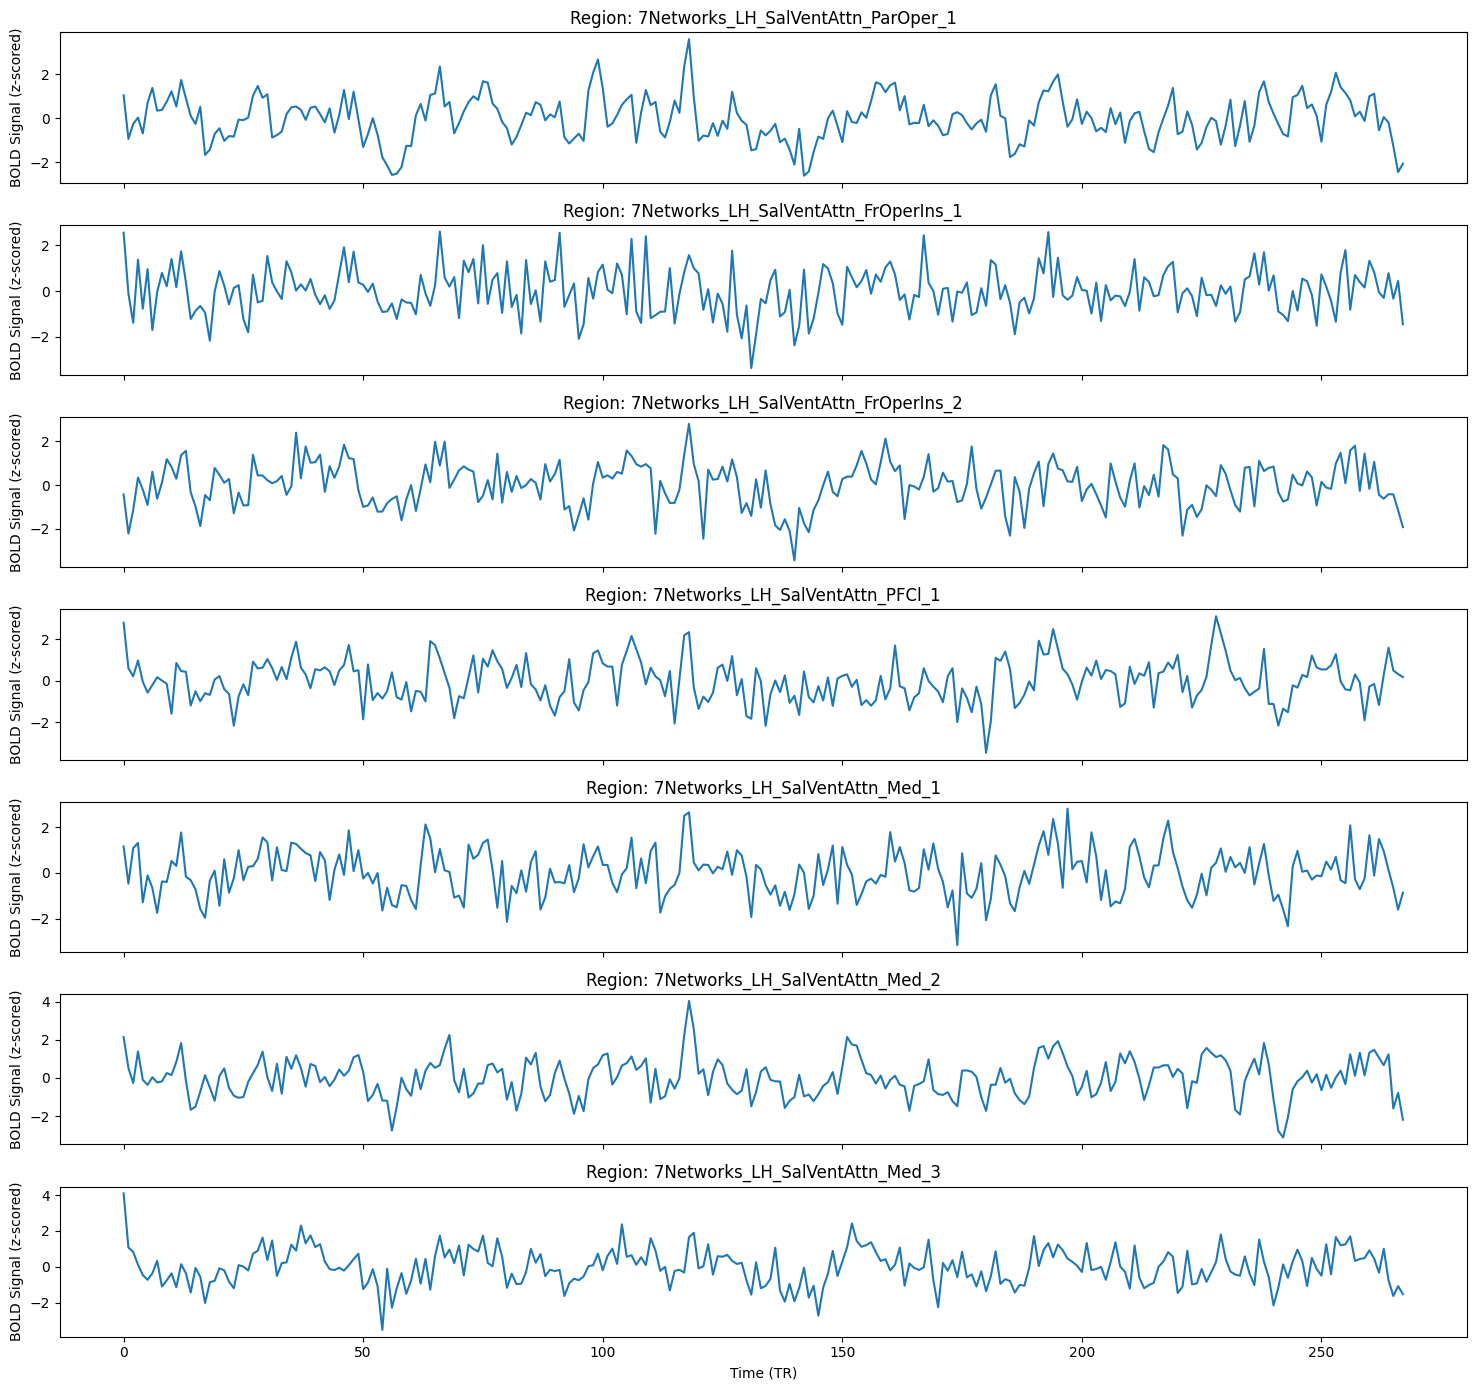

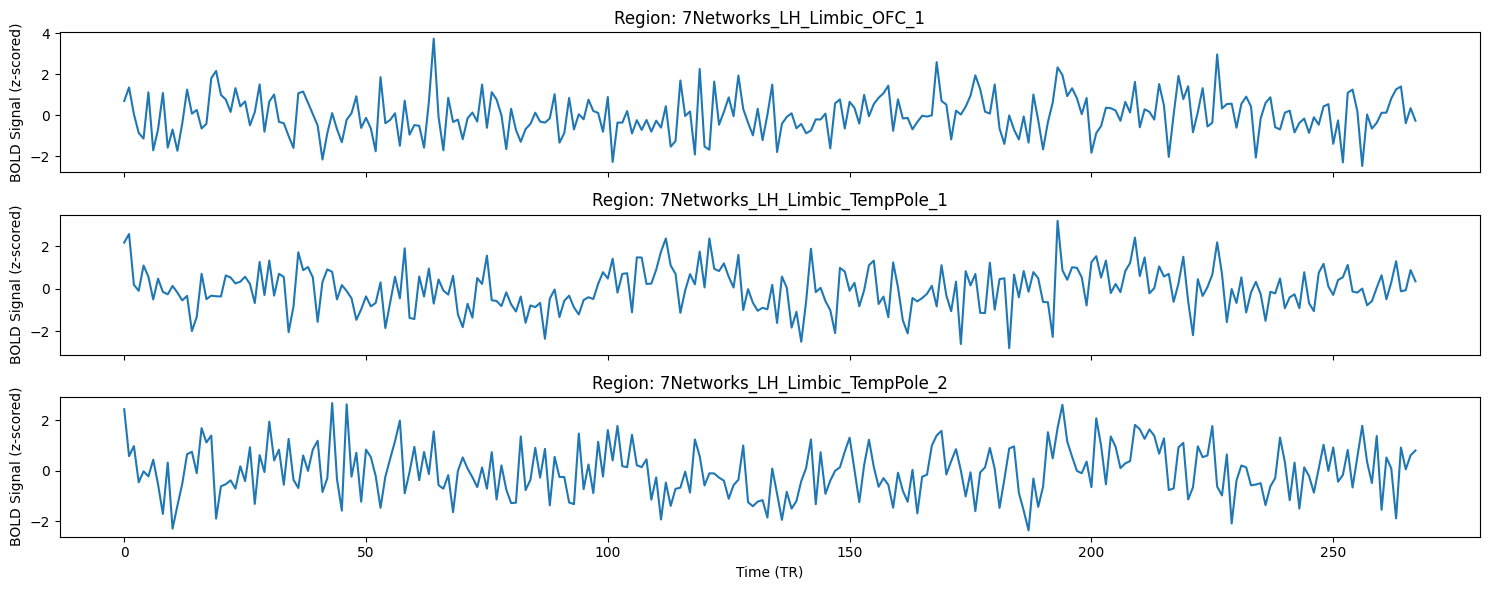

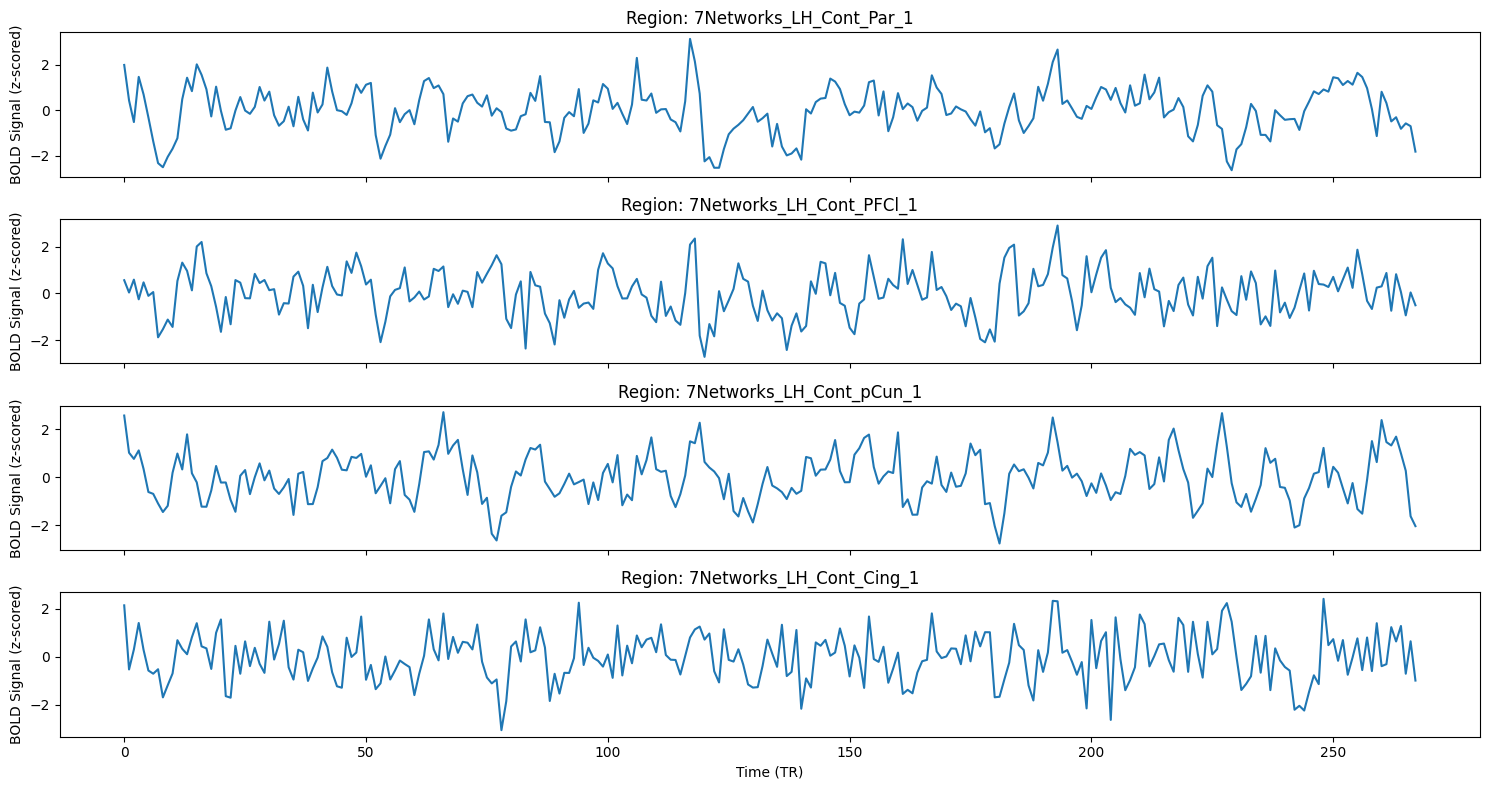

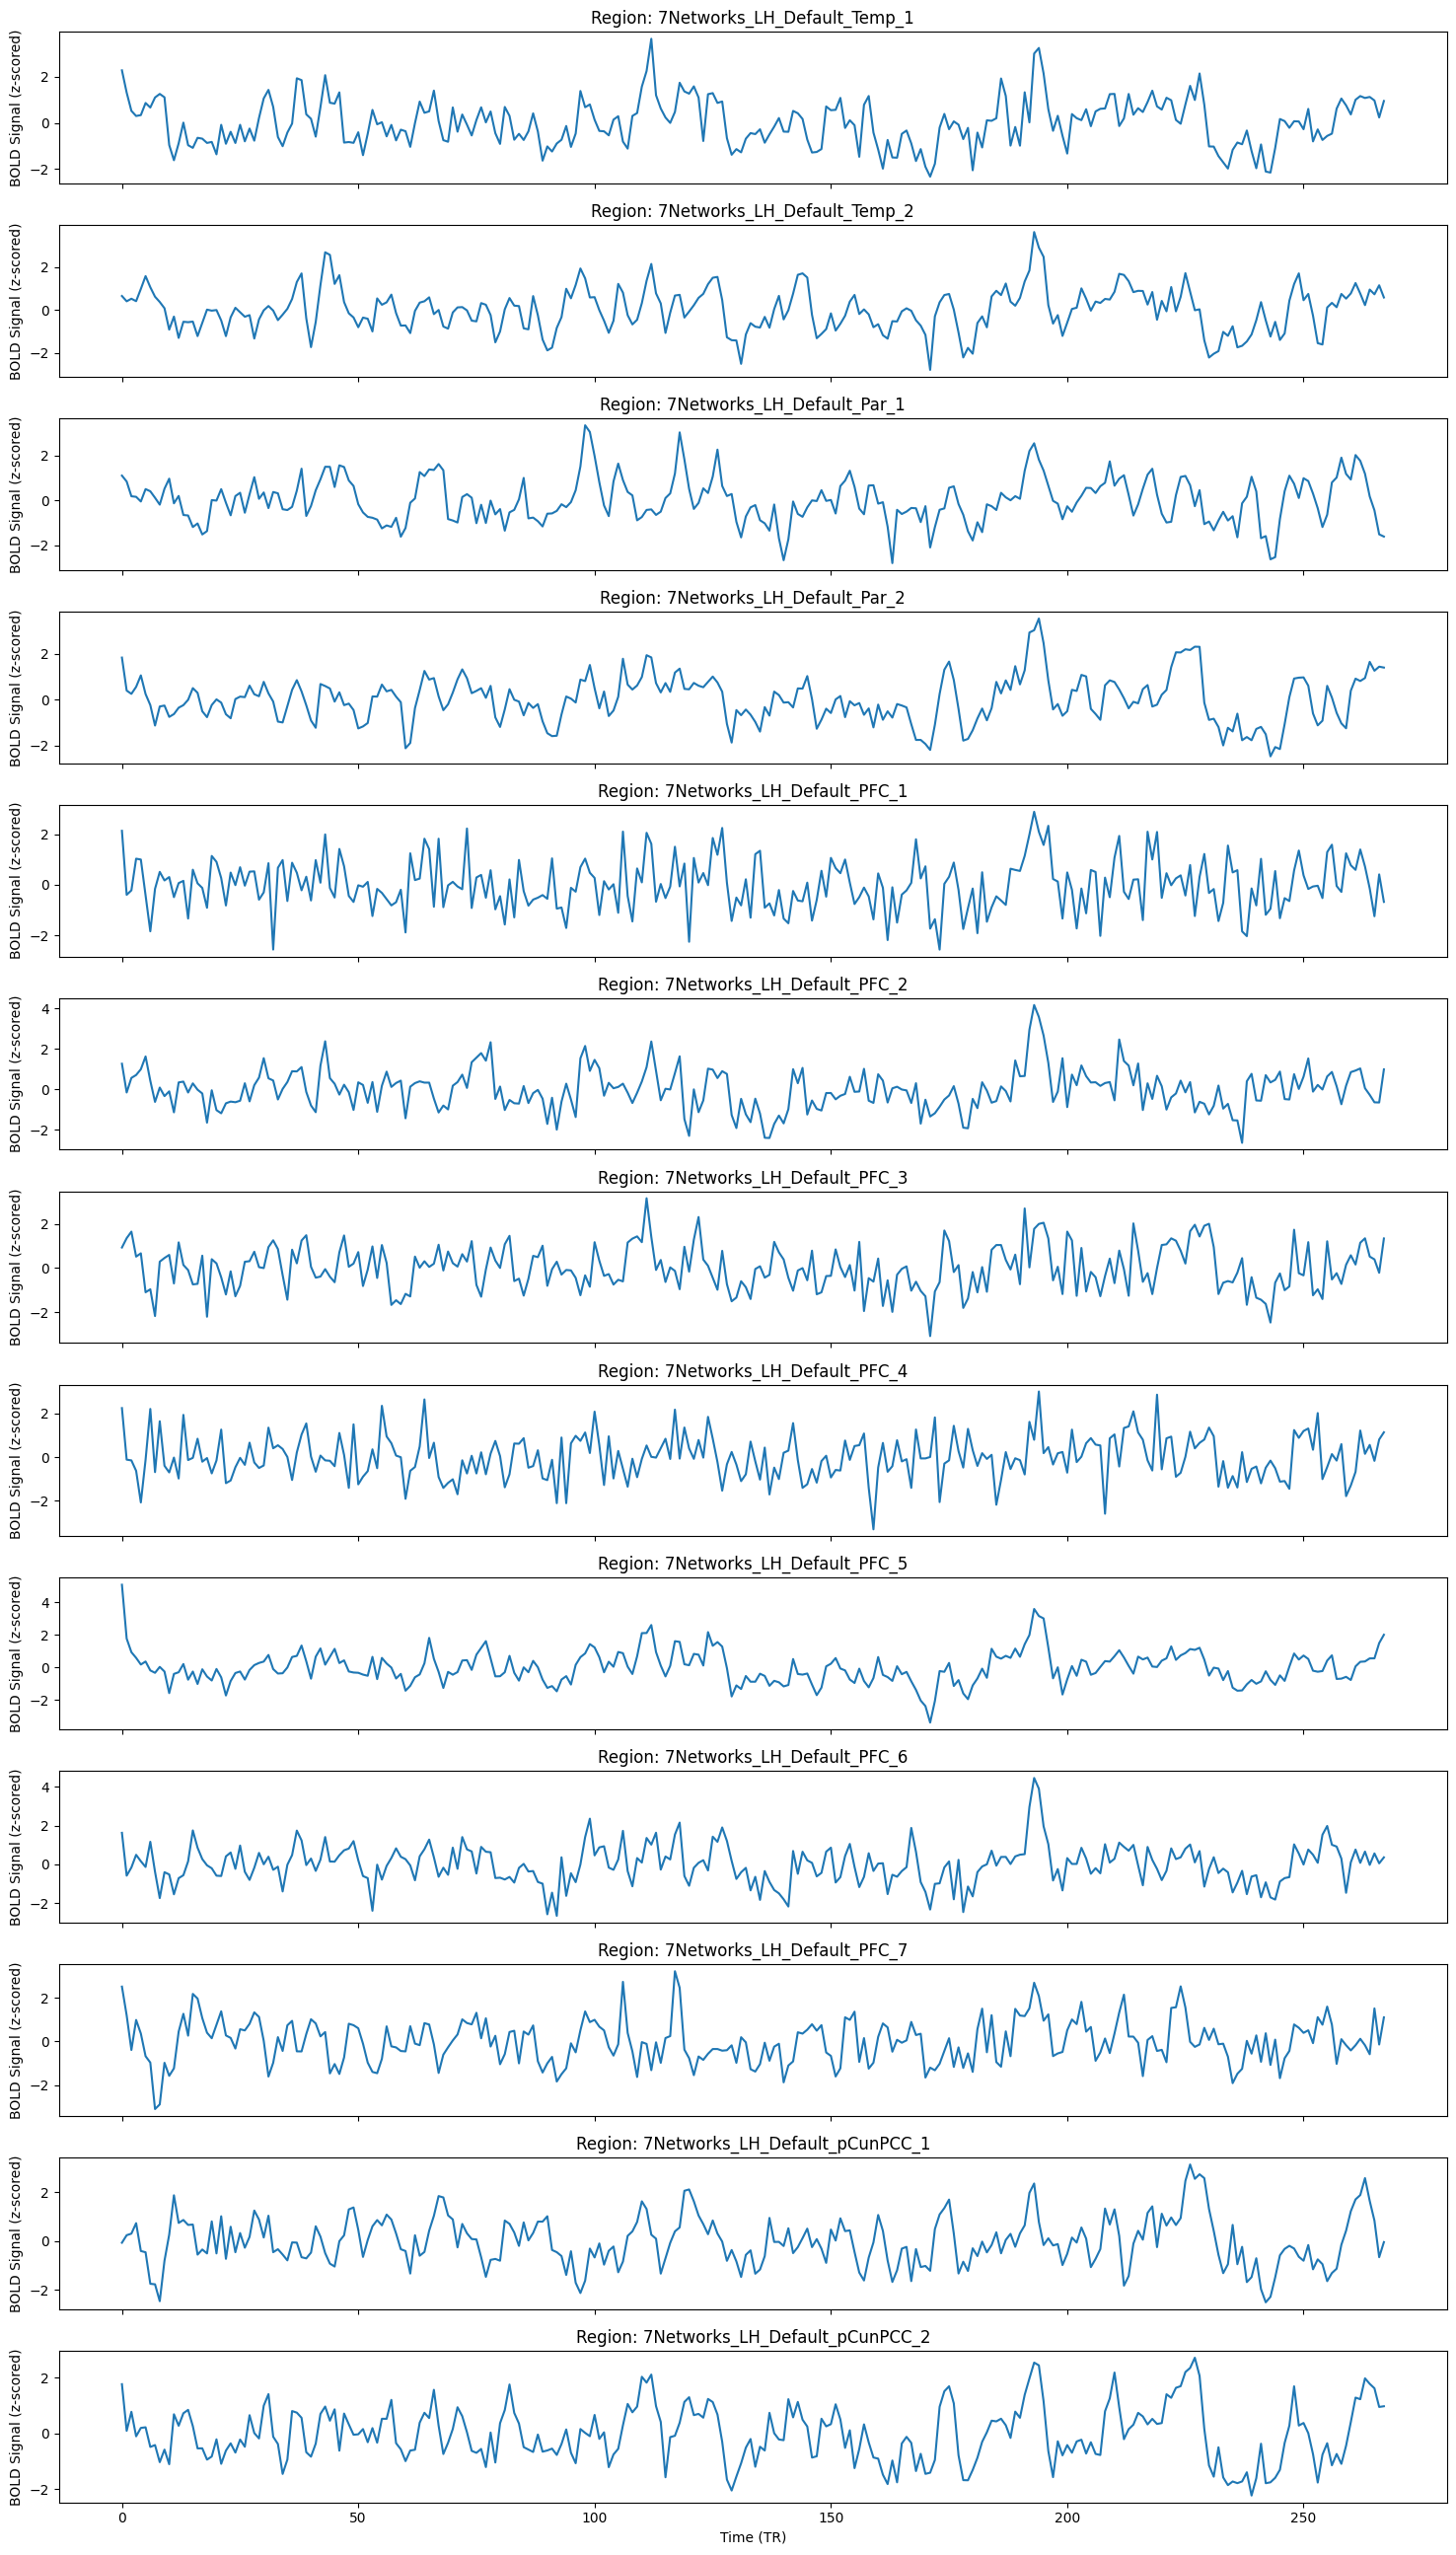

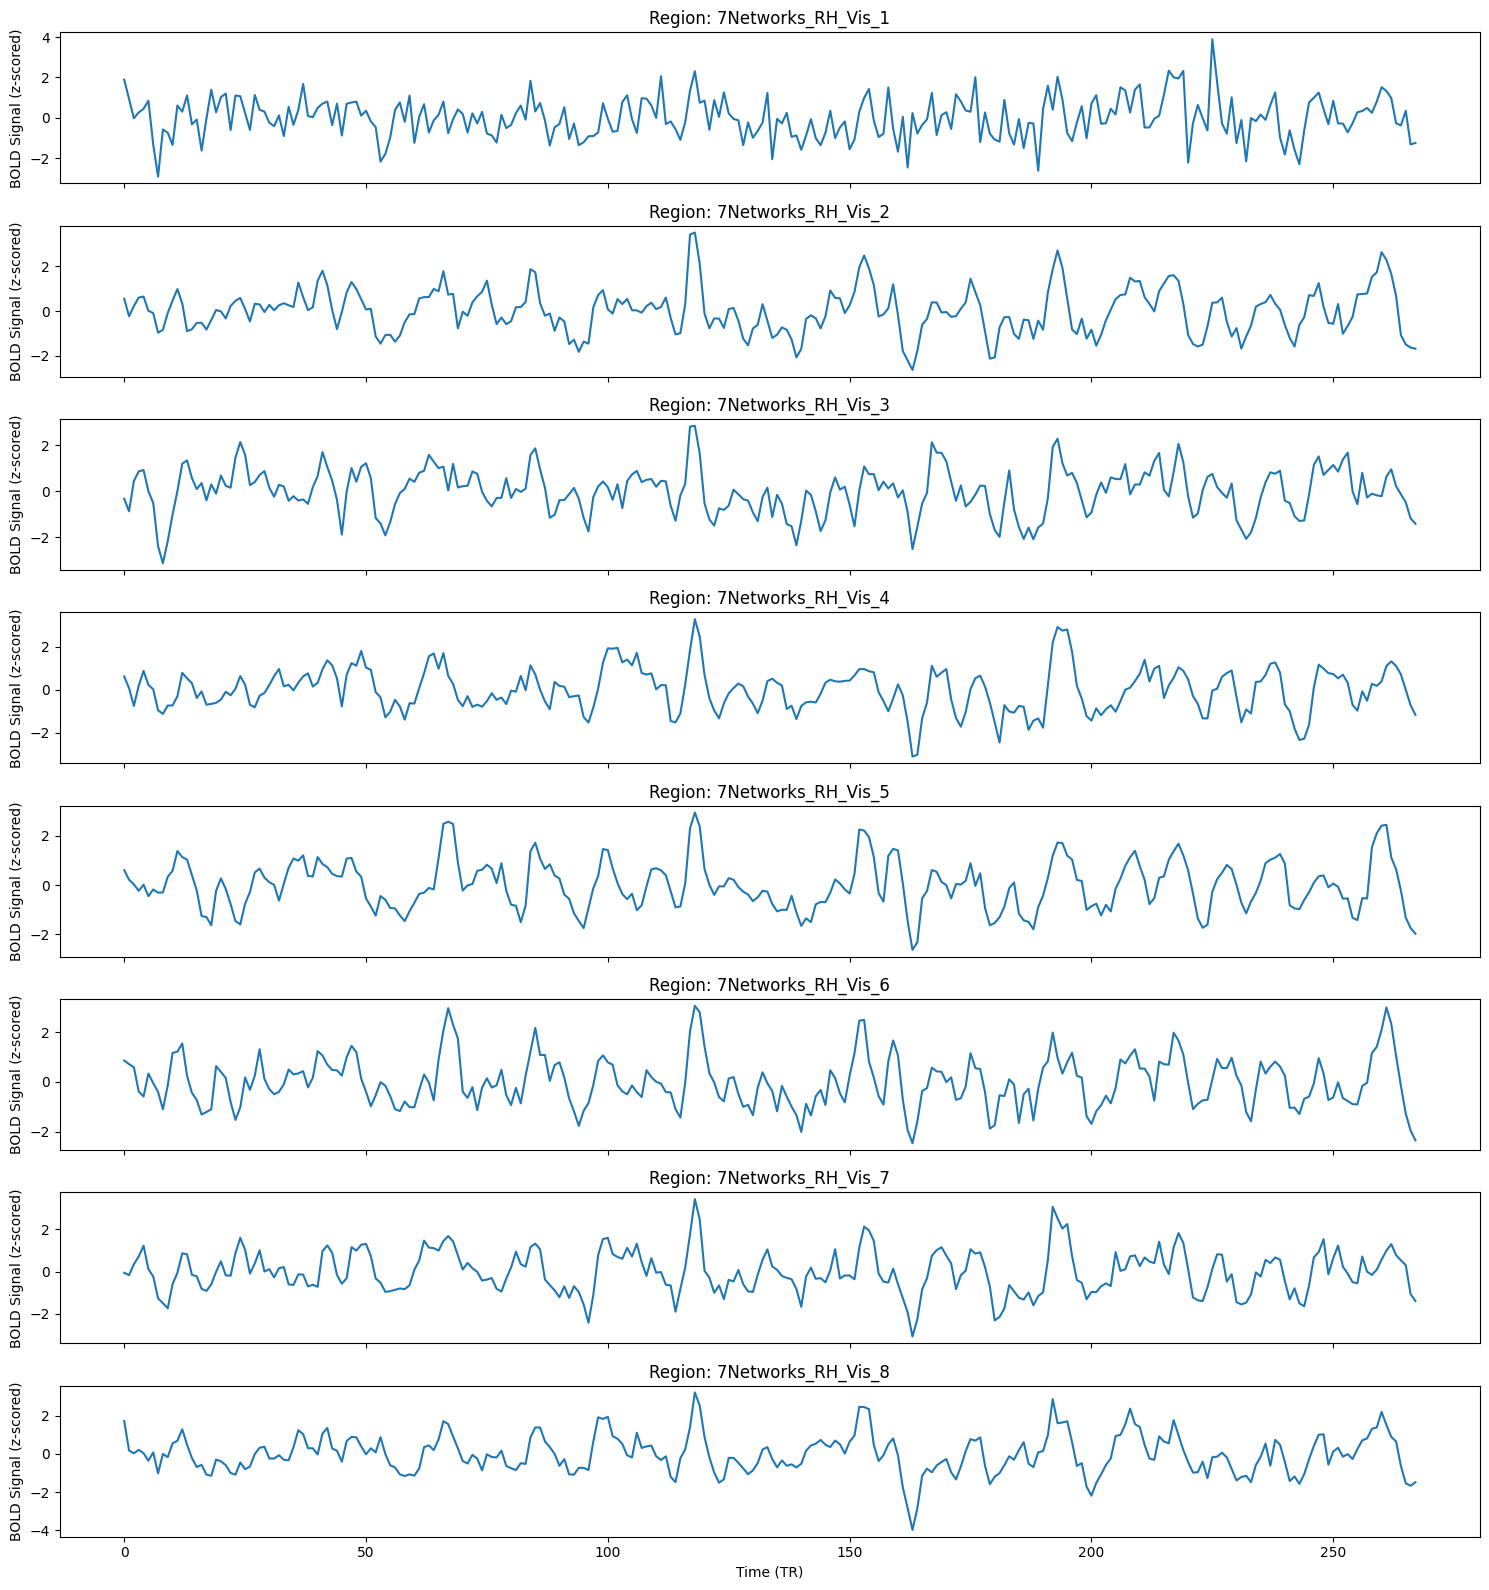

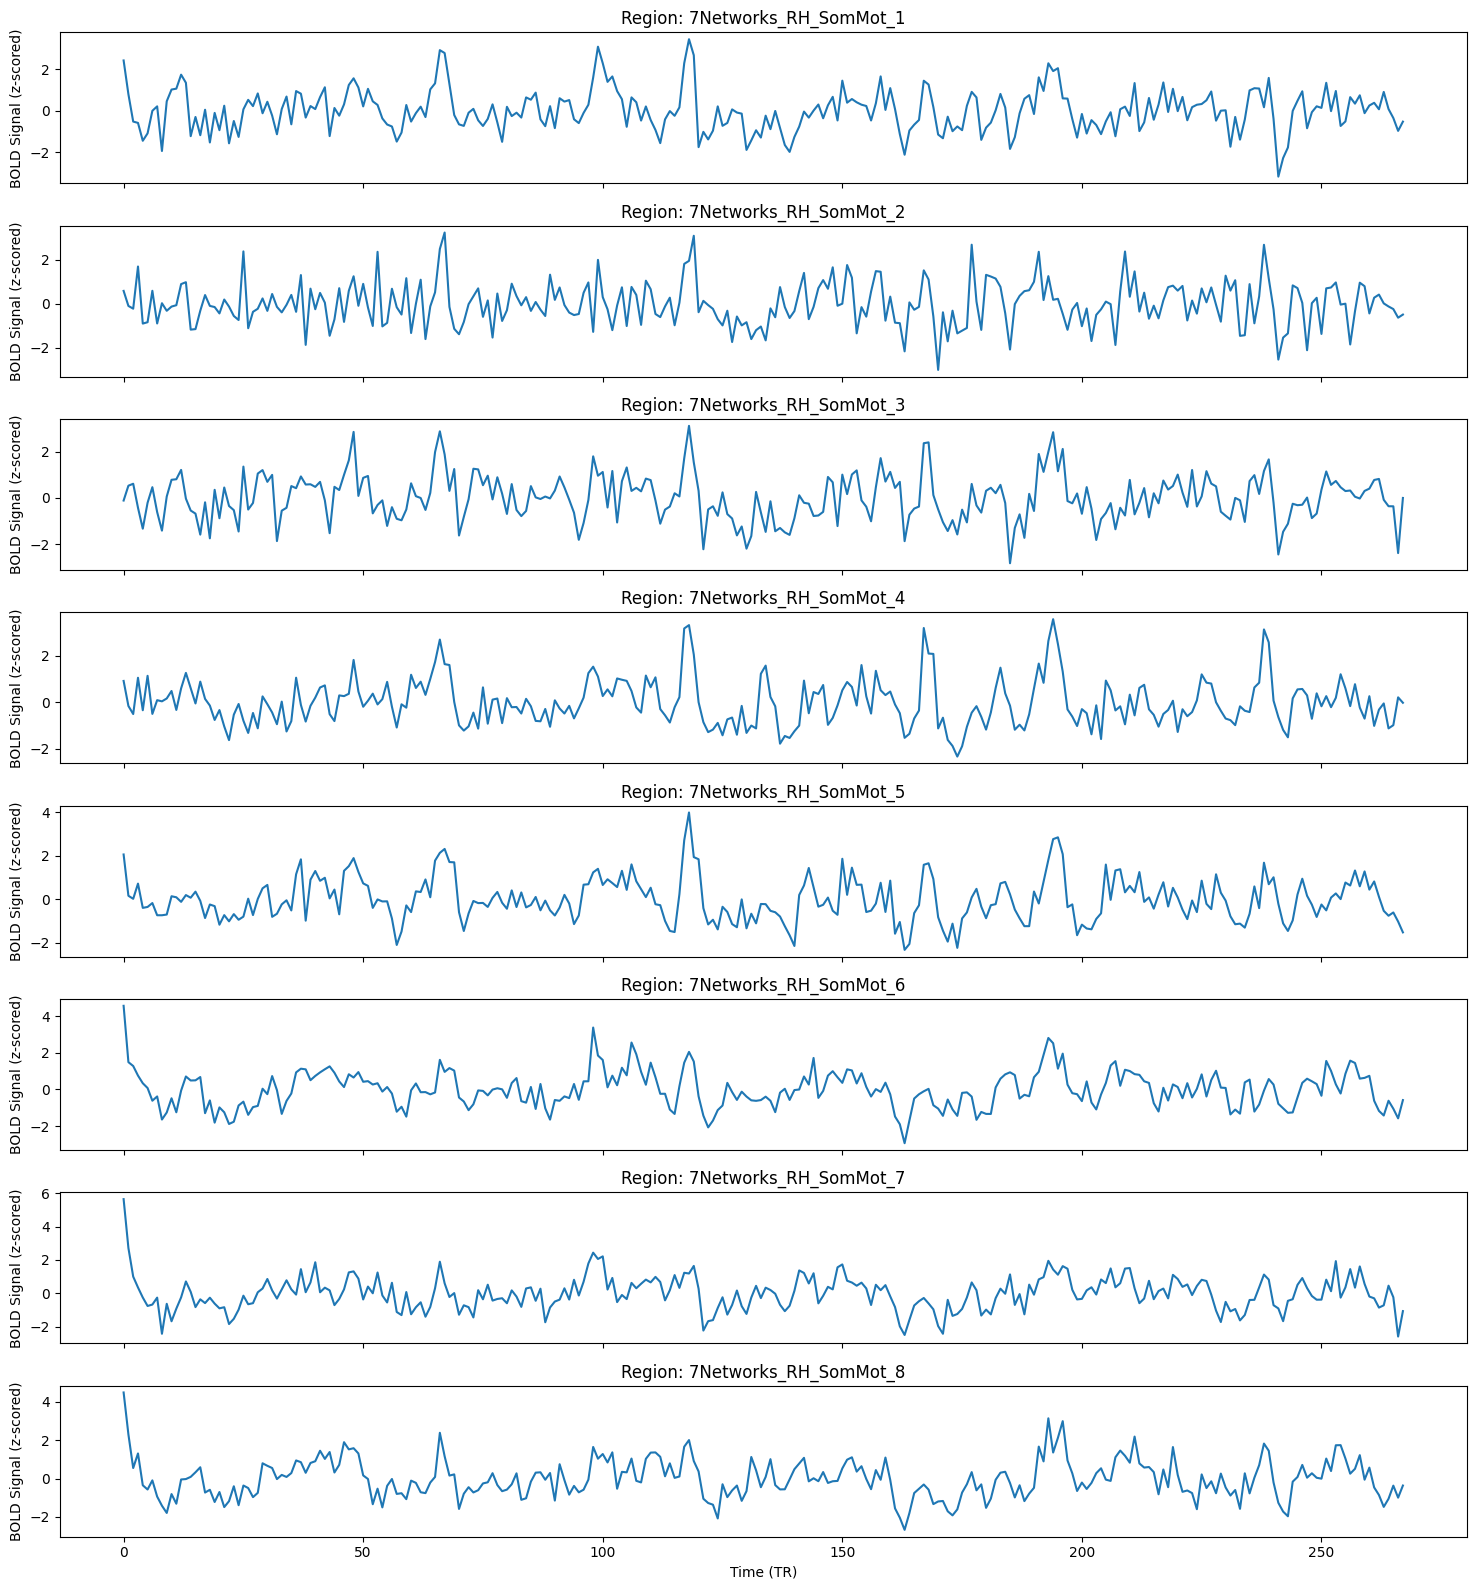

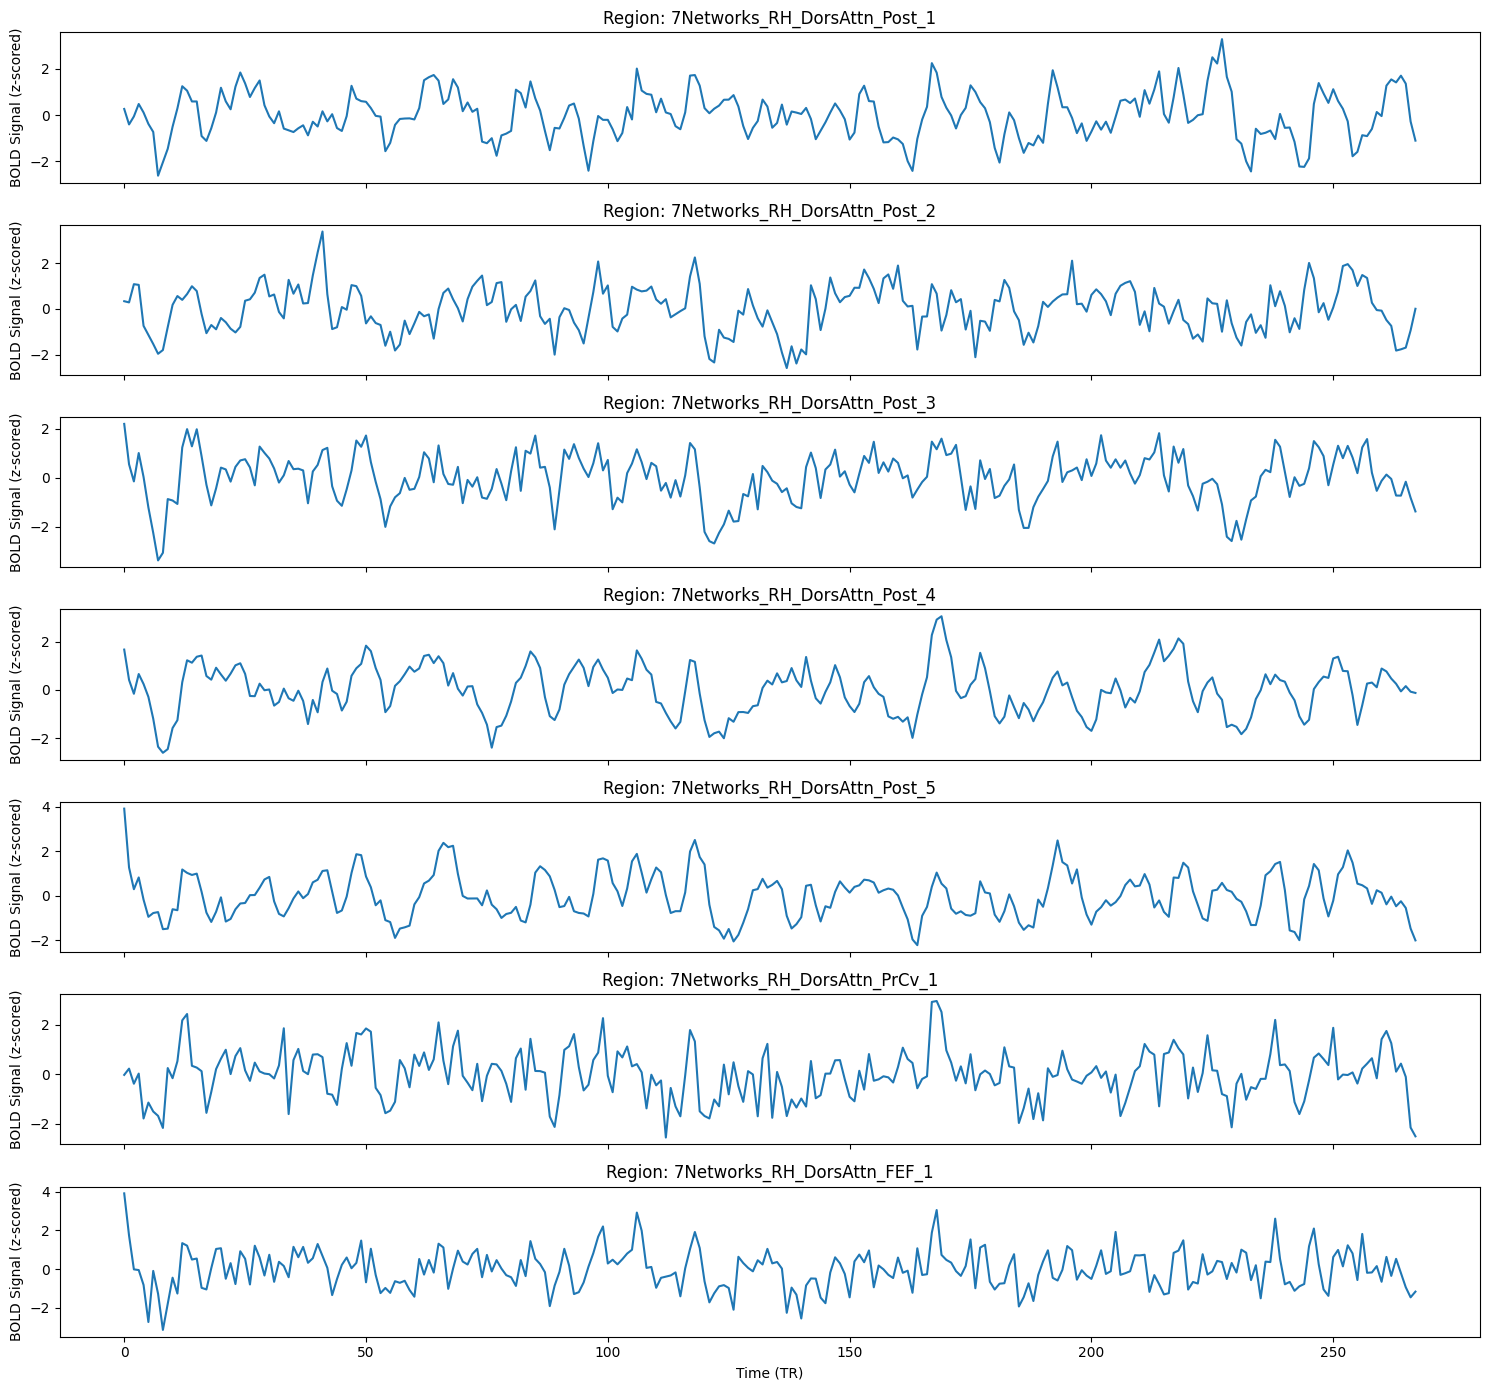

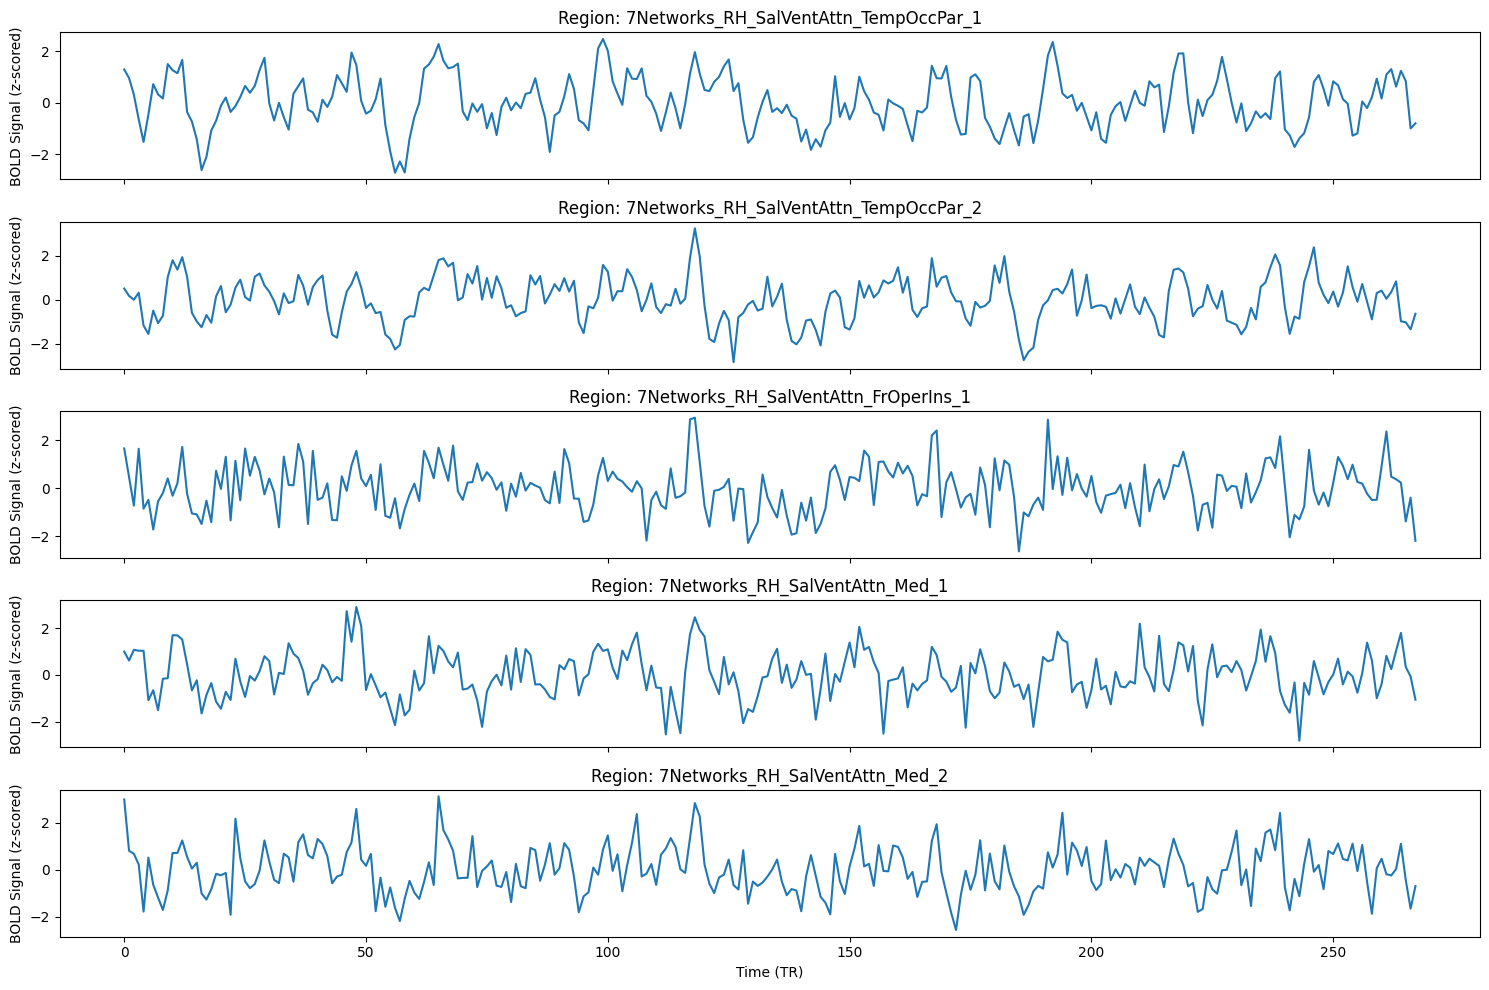

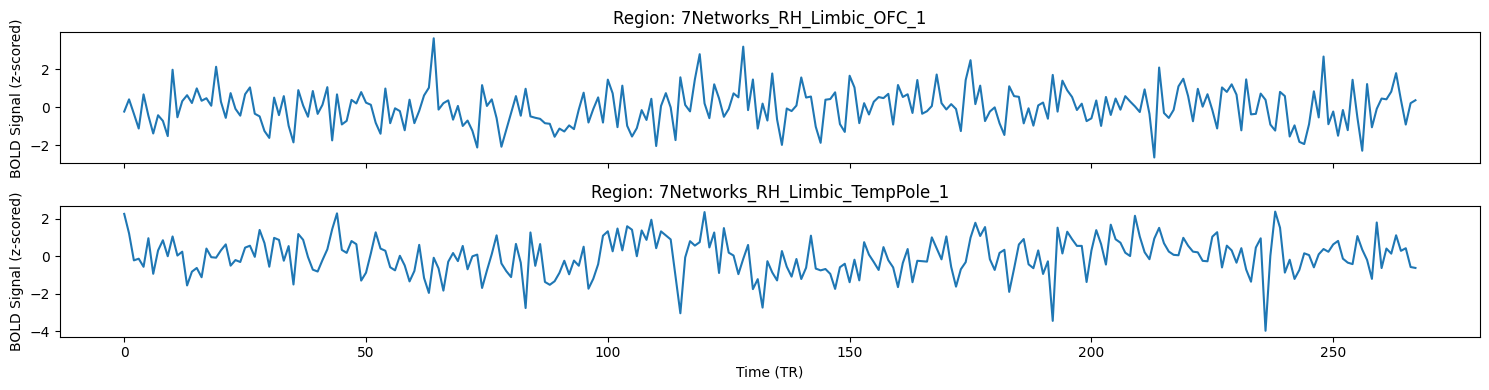

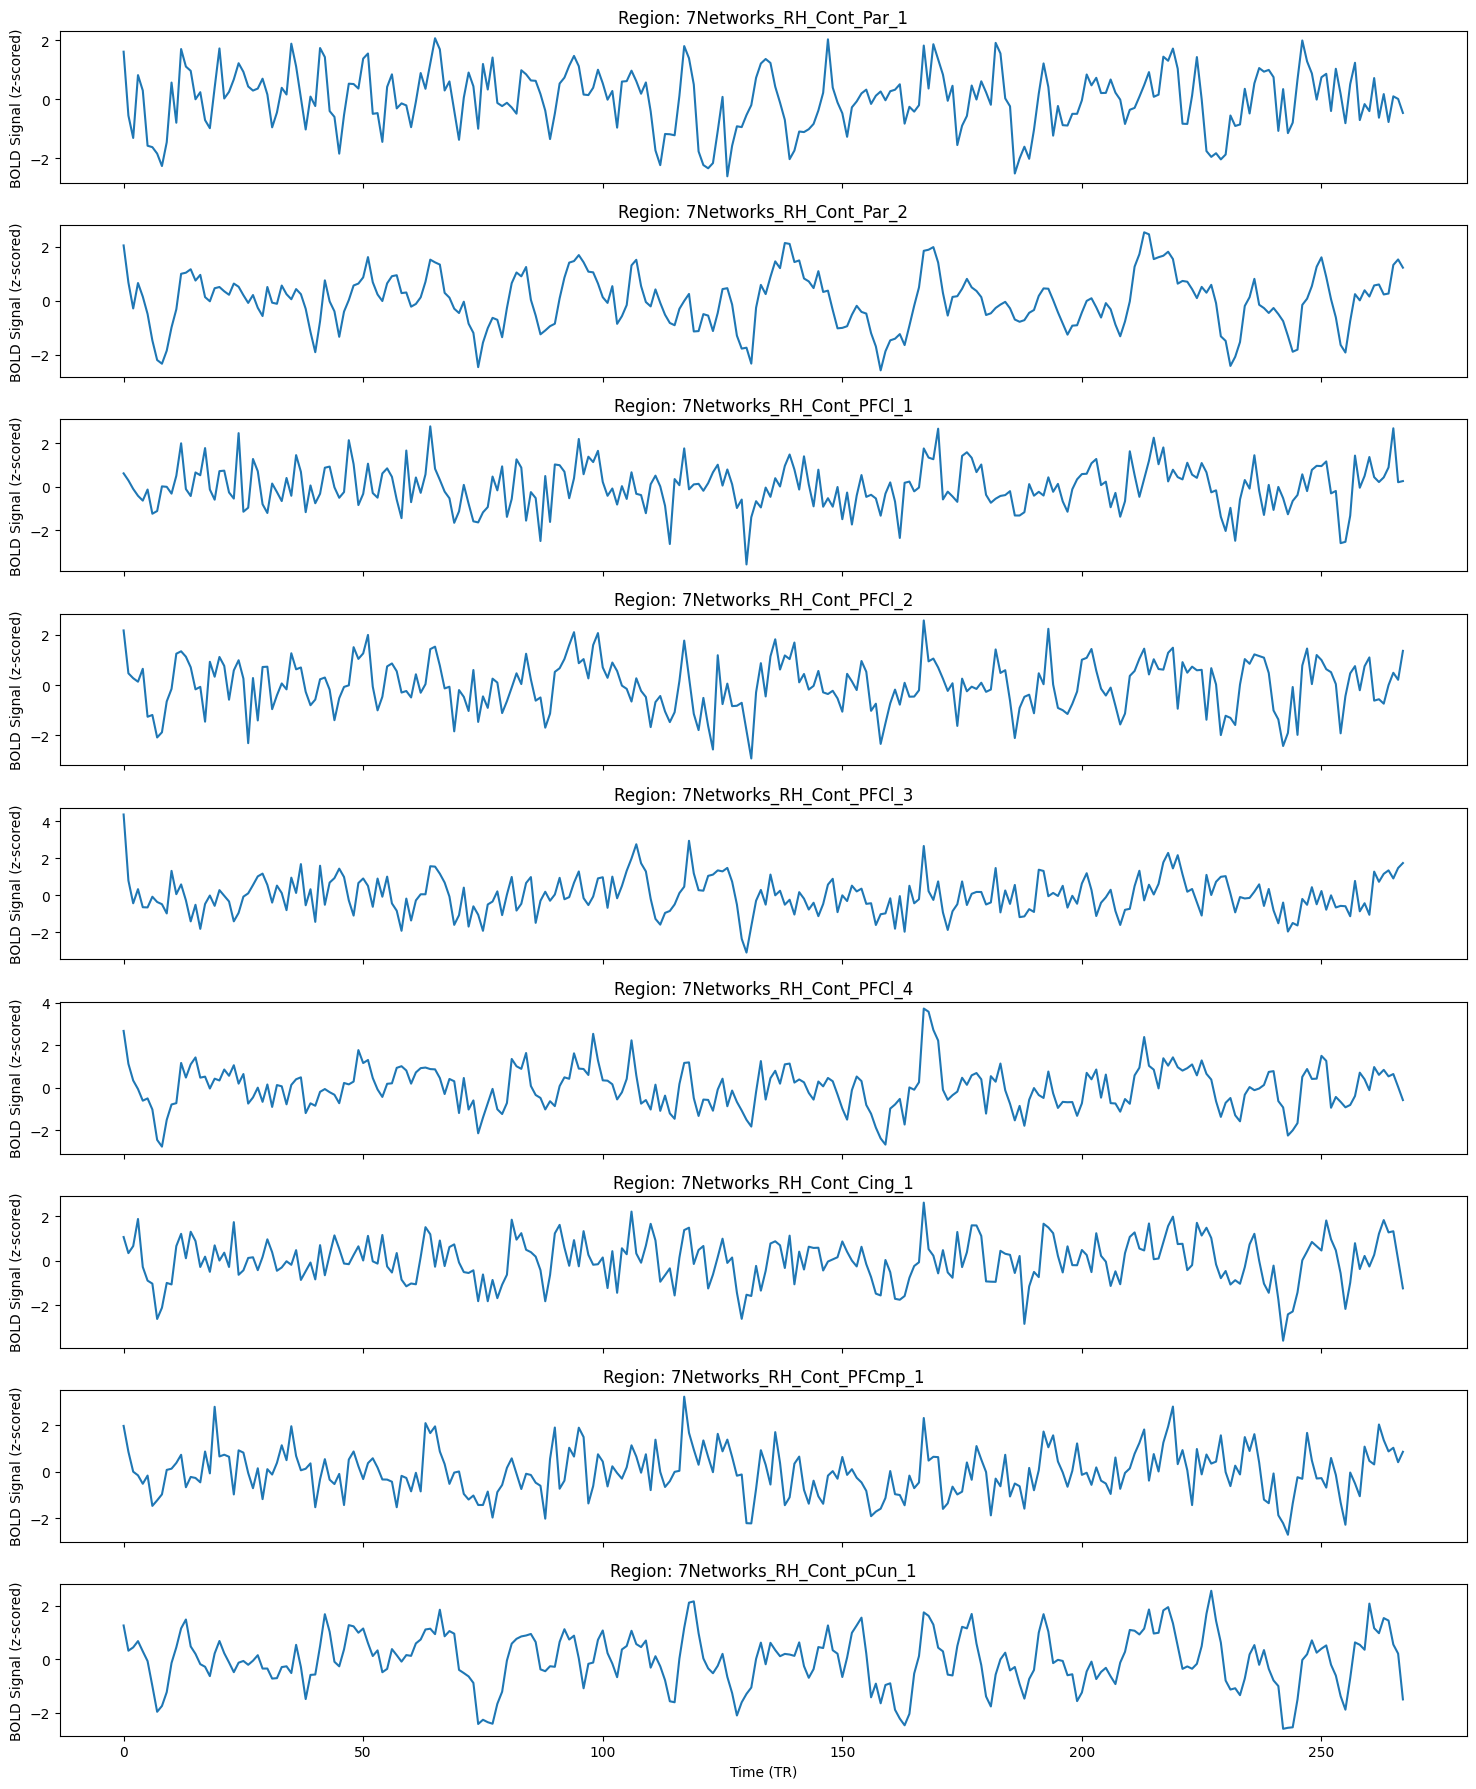

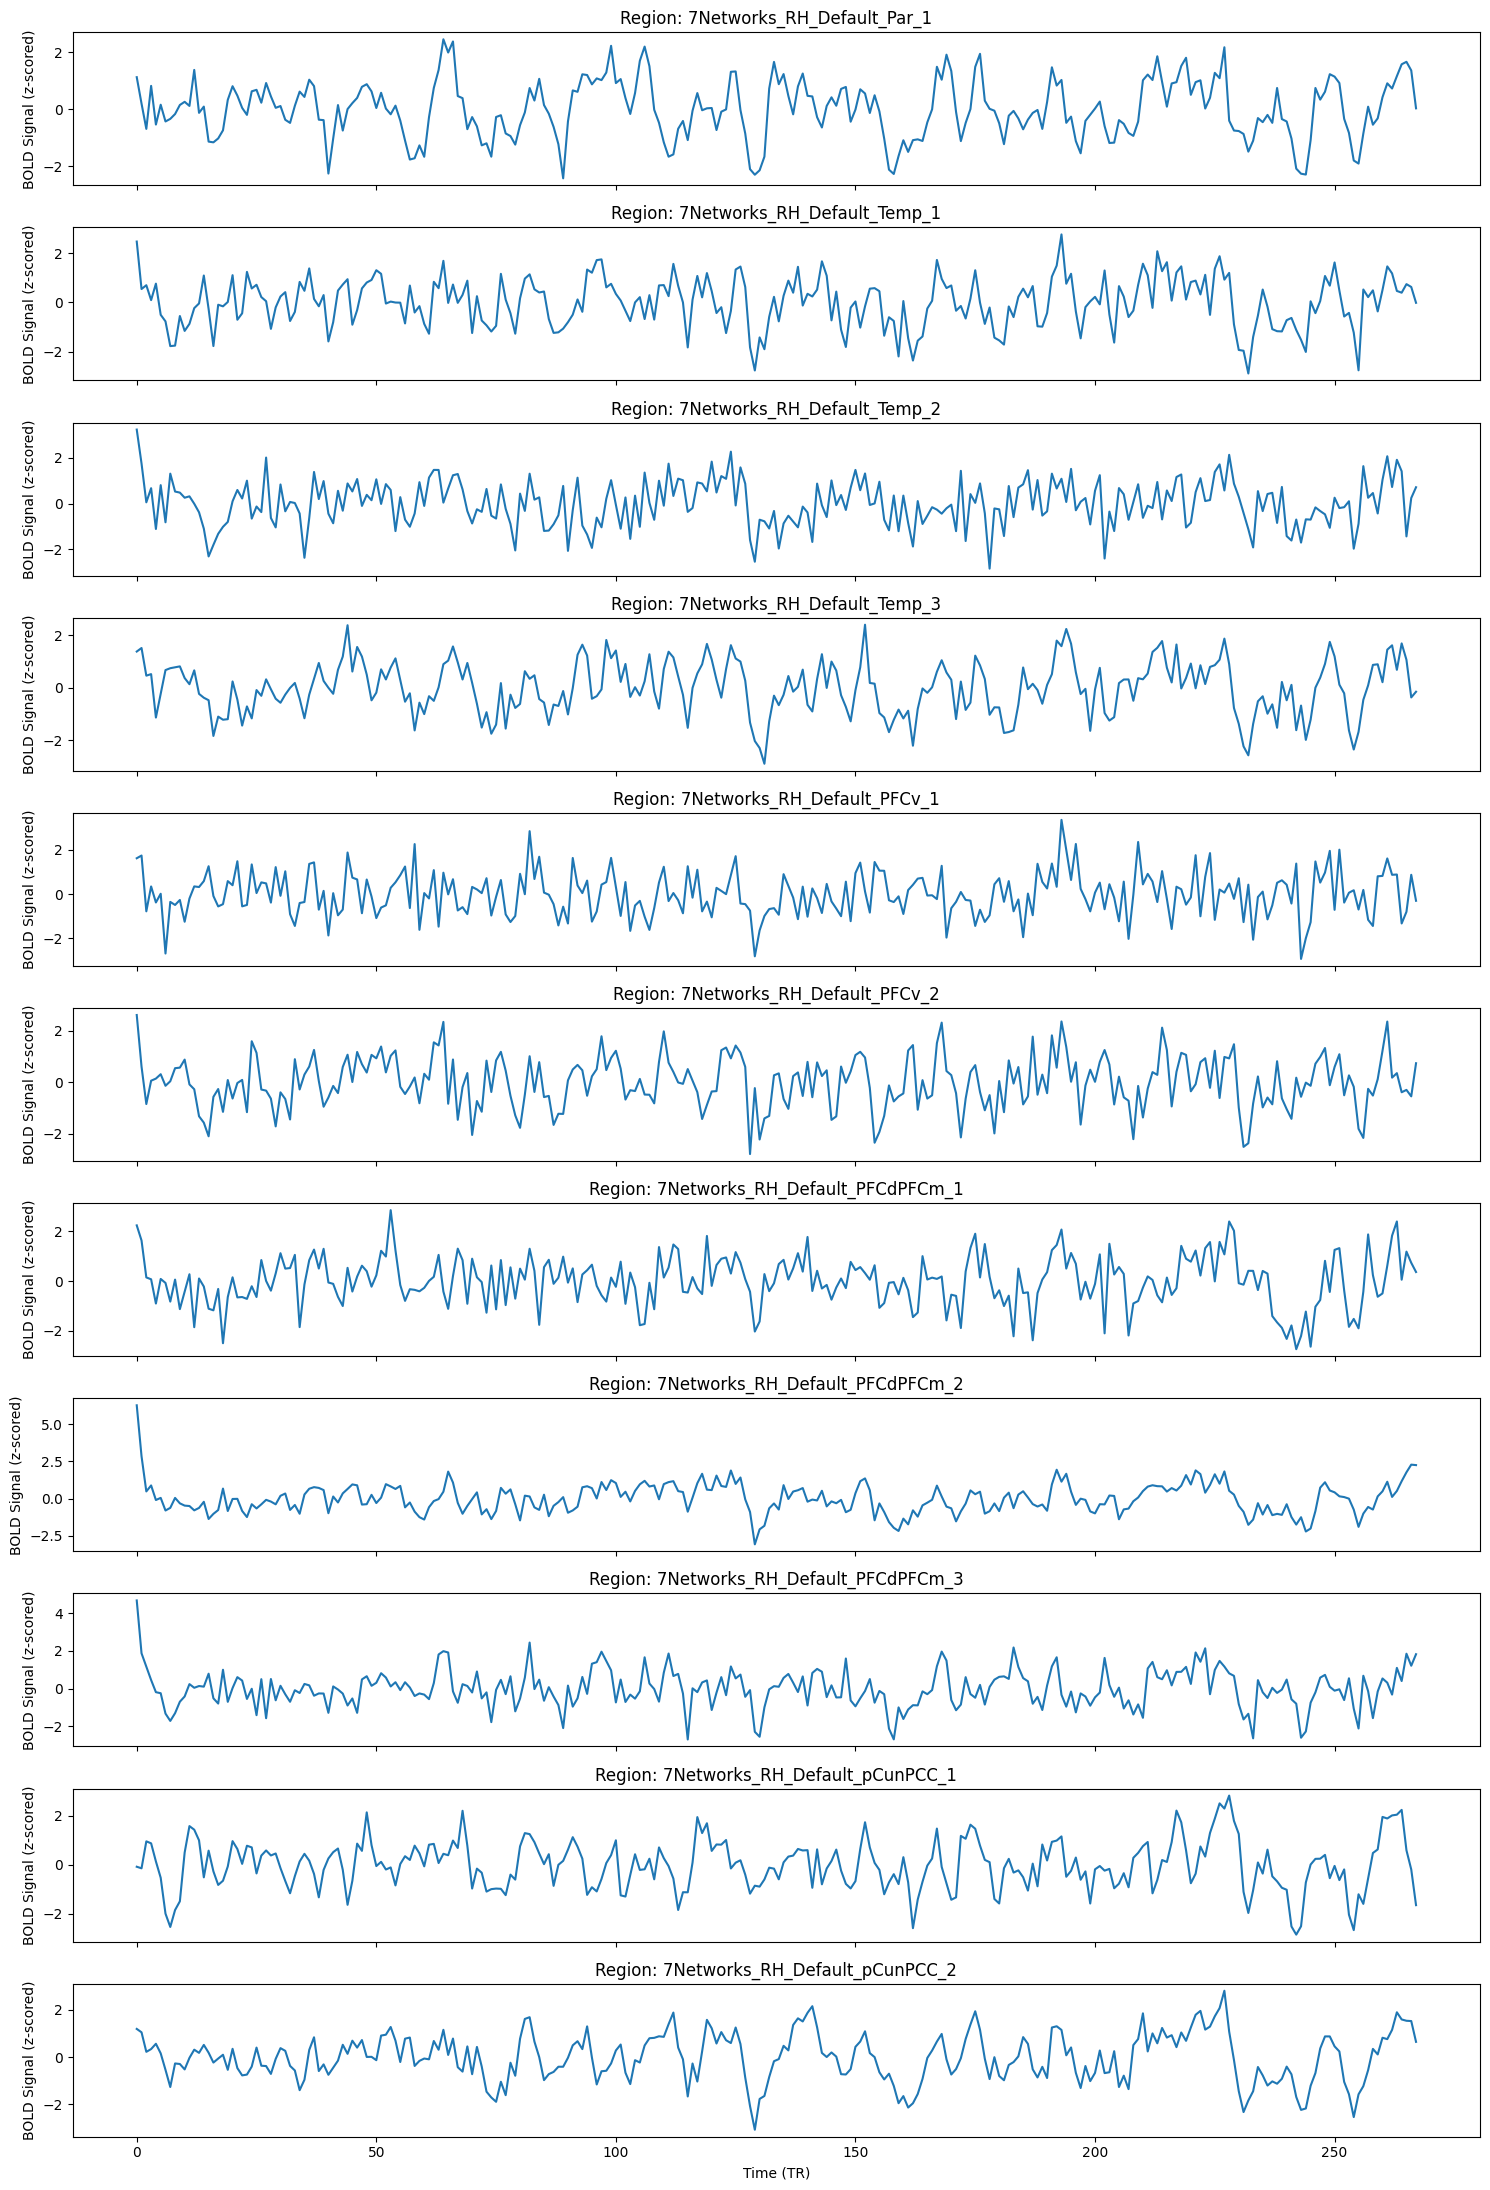

In [12]:
# Define the network prefixes for both hemispheres
network_prefixes = ['7Networks_LH_Vis', '7Networks_LH_SomMot', '7Networks_LH_DorsAttn', 
                    '7Networks_LH_SalVentAttn', '7Networks_LH_Limbic', '7Networks_LH_Cont', 
                    '7Networks_LH_Default', '7Networks_RH_Vis', '7Networks_RH_SomMot', 
                    '7Networks_RH_DorsAttn', '7Networks_RH_SalVentAttn', '7Networks_RH_Limbic', 
                    '7Networks_RH_Cont', '7Networks_RH_Default']

# Create a dictionary to hold the indices of regions for each network
network_indices = {prefix: [] for prefix in network_prefixes}

# Populate the dictionary with indices
for idx, region in enumerate(region_names):
    for prefix in network_prefixes:
        if region.startswith(prefix):
            network_indices[prefix].append(idx)
            break

# Plot time series for each network
for prefix, indices in network_indices.items():
    fig, ax = plt.subplots(len(indices), 1, figsize=(15, len(indices) * 2), sharex=True)
    for i, region_idx in enumerate(indices):
        ax[i].plot(time_series[:, region_idx])
        ax[i].set_title(f"Region: {region_names[region_idx]}")
        ax[i].set_ylabel("BOLD Signal (z-scored)")
    
    ax[-1].set_xlabel("Time (TR)")
    plt.tight_layout()
    plt.savefig(f'Images/time_series_{prefix}.png')
    plt.show()


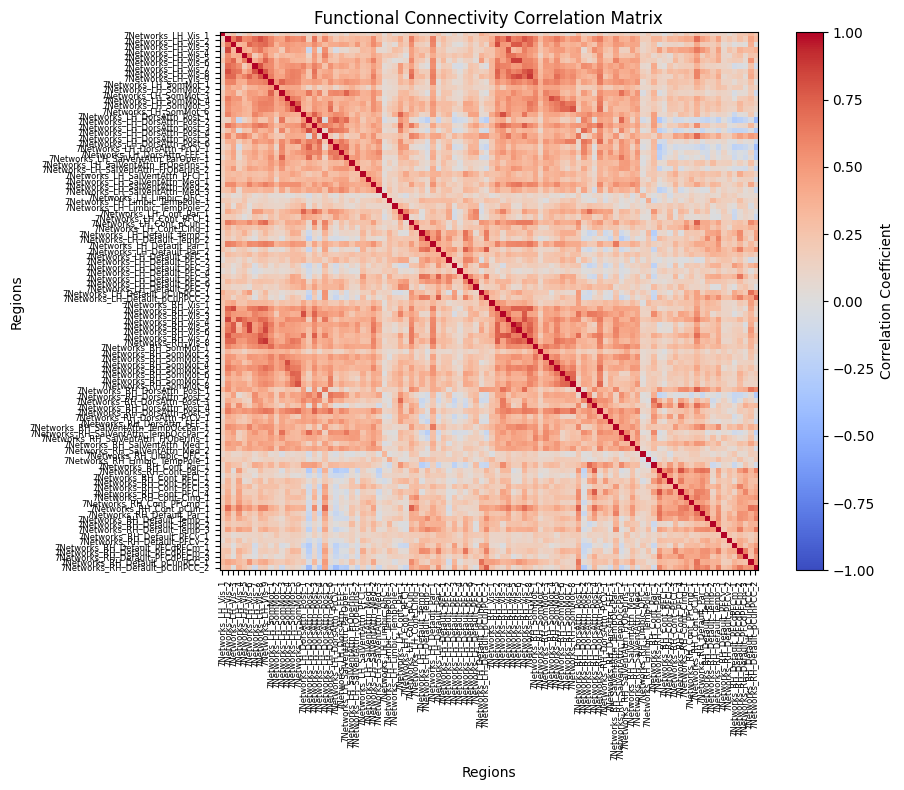

Maximum correlation value: 1.0
Minimum correlation value: -0.407302638422734


In [9]:
# Calculate the pearson correlation matrix
correlation_matrix = np.corrcoef(time_series.T)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.title('Functional Connectivity Correlation Matrix')
plt.xlabel('Regions')
plt.ylabel('Regions')
plt.xticks(ticks=np.arange(len(region_names)), labels=region_names, rotation=90, fontsize=6)
plt.yticks(ticks=np.arange(len(region_names)), labels=region_names, fontsize=6)
plt.tight_layout()
plt.savefig('Images/correlation_matrix.png')
plt.show()
# Print the maximum and minimum correlation values
max_corr = np.max(correlation_matrix)
min_corr = np.min(correlation_matrix)
print(f"Maximum correlation value: {max_corr}")
print(f"Minimum correlation value: {min_corr}")


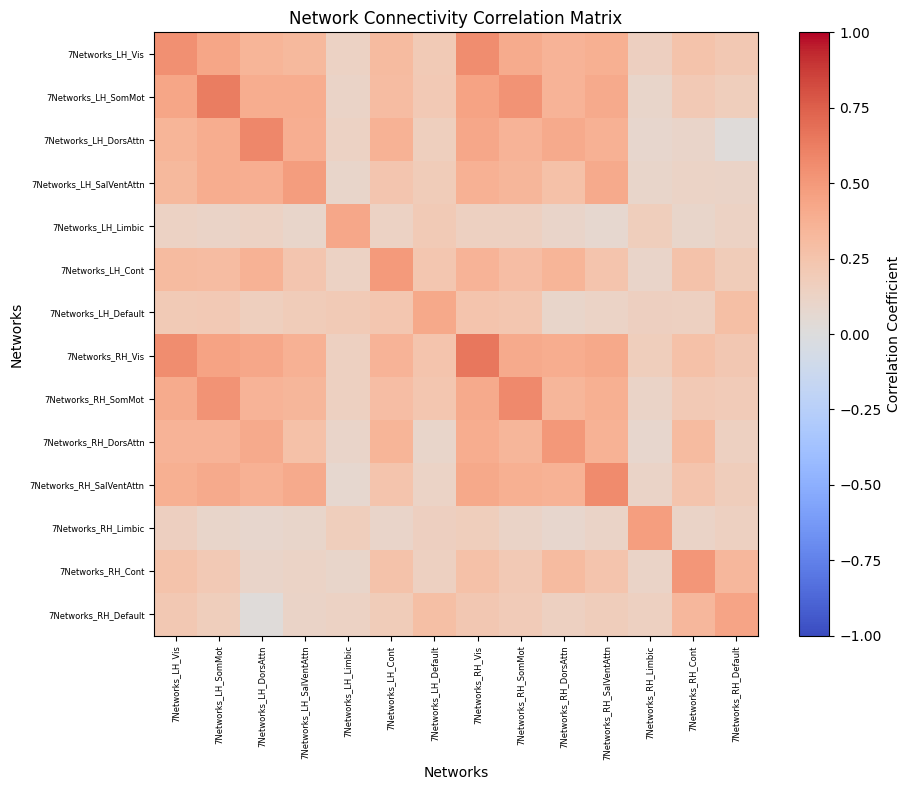

In [15]:
# Initialize an empty matrix to hold the average correlation values
network_correlation_matrix = np.zeros((len(network_prefixes), len(network_prefixes)))

# Calculate the average correlation for each network pair
for i, prefix_i in enumerate(network_prefixes):
    for j, prefix_j in enumerate(network_prefixes):
        indices_i = network_indices[prefix_i]
        indices_j = network_indices[prefix_j]
        
        # Extract the submatrix for the current network pair
        submatrix = correlation_matrix[np.ix_(indices_i, indices_j)]
        
        # Calculate the average value of the submatrix
        average_value = np.mean(submatrix)
        
        # Assign the average value to the corresponding entry in the new matrix
        network_correlation_matrix[i, j] = average_value

# Plot the network correlation matrix
plt.figure(figsize=(10, 8))
plt.imshow(network_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.title('Network Connectivity Correlation Matrix')
plt.xlabel('Networks')
plt.ylabel('Networks')
plt.xticks(ticks=np.arange(len(network_prefixes)), labels=network_prefixes, rotation=90, fontsize=6)
plt.yticks(ticks=np.arange(len(network_prefixes)), labels=network_prefixes, fontsize=6)
plt.tight_layout()
plt.savefig('Images/network_correlation_matrix.png')
plt.show()

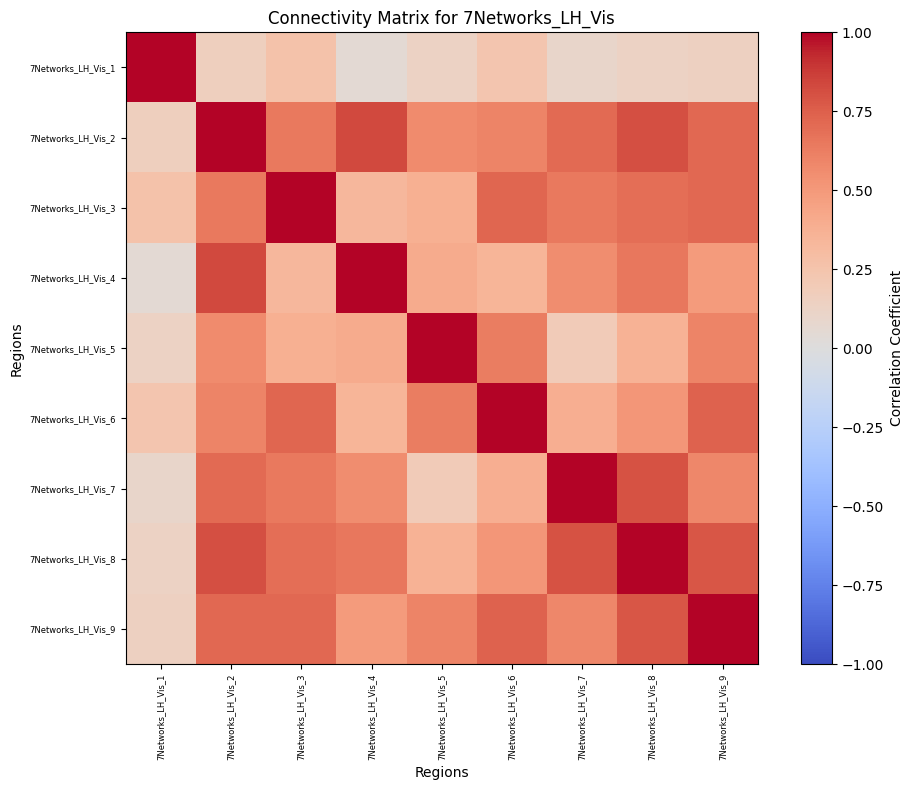

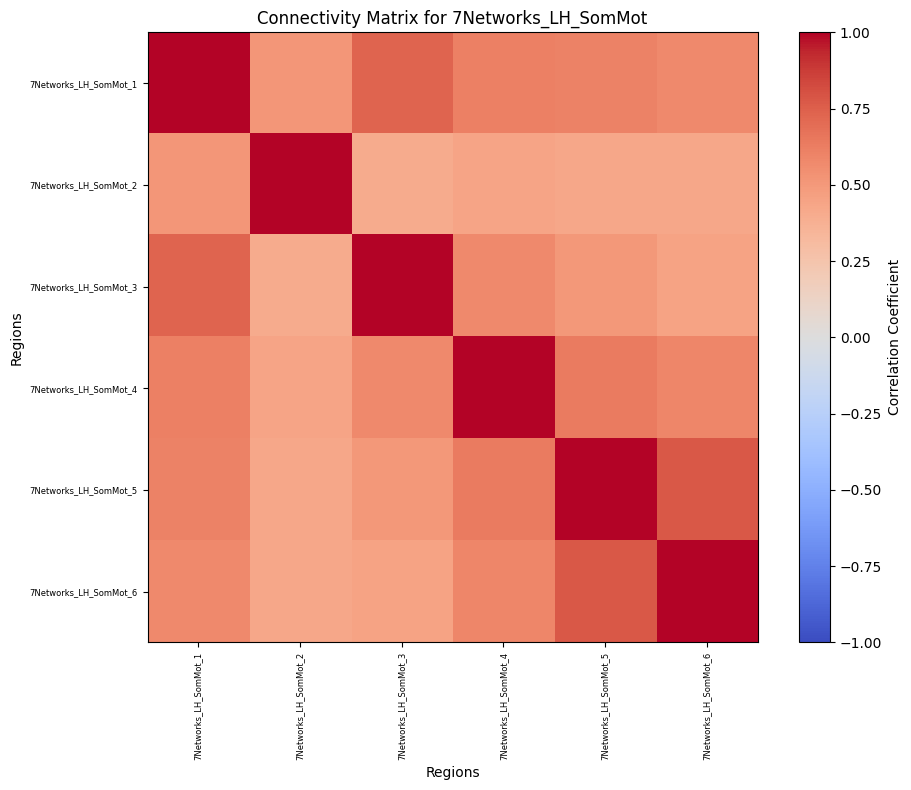

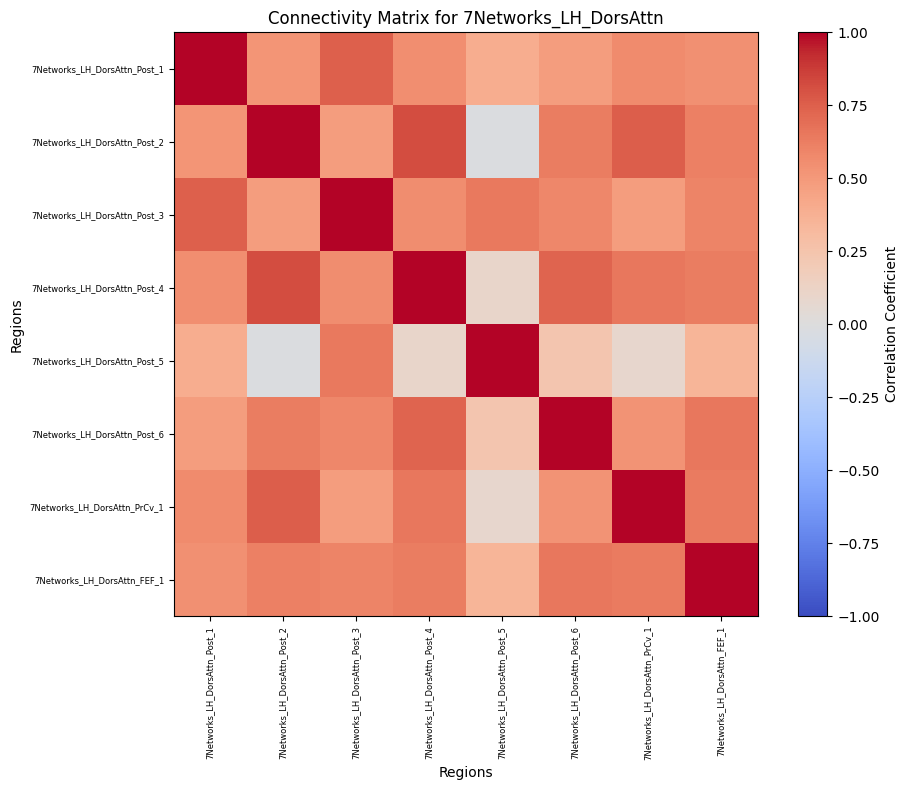

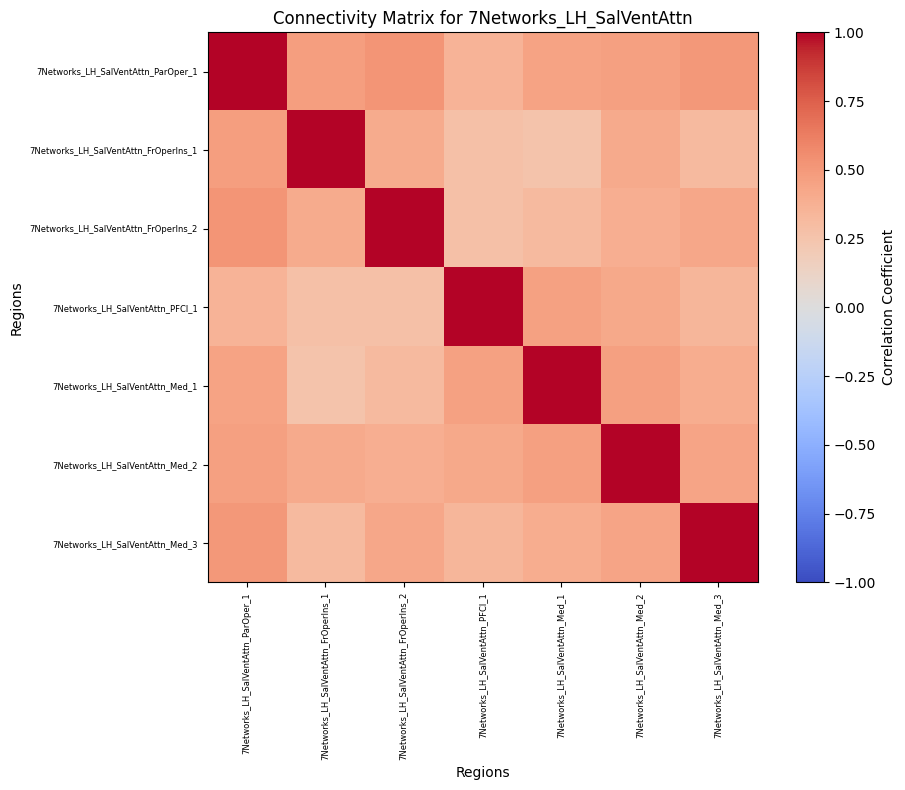

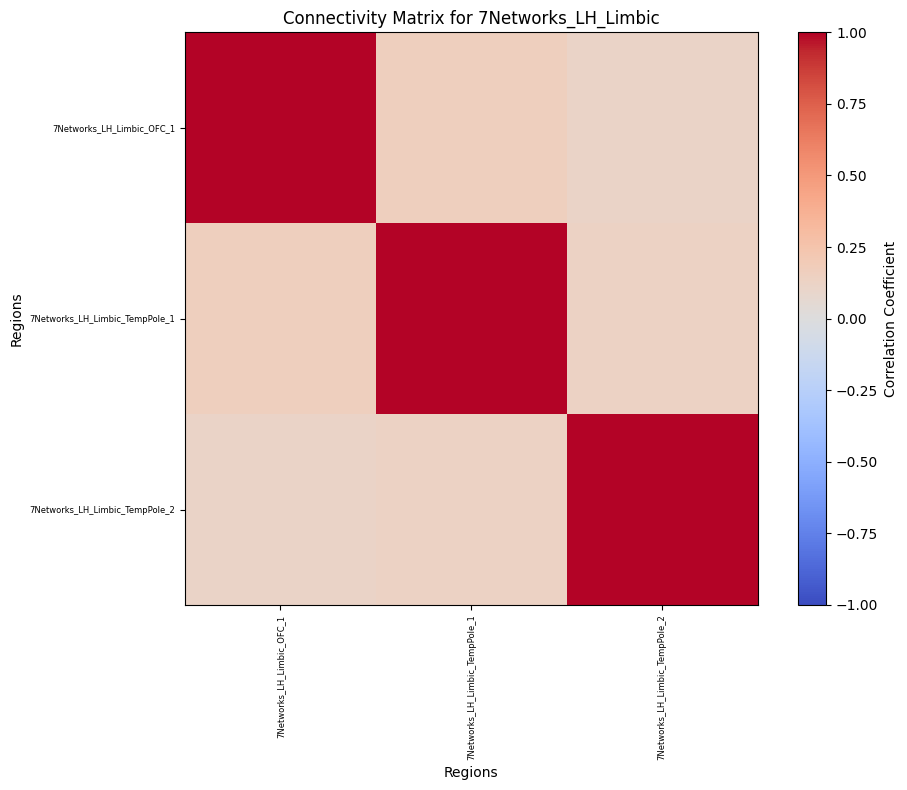

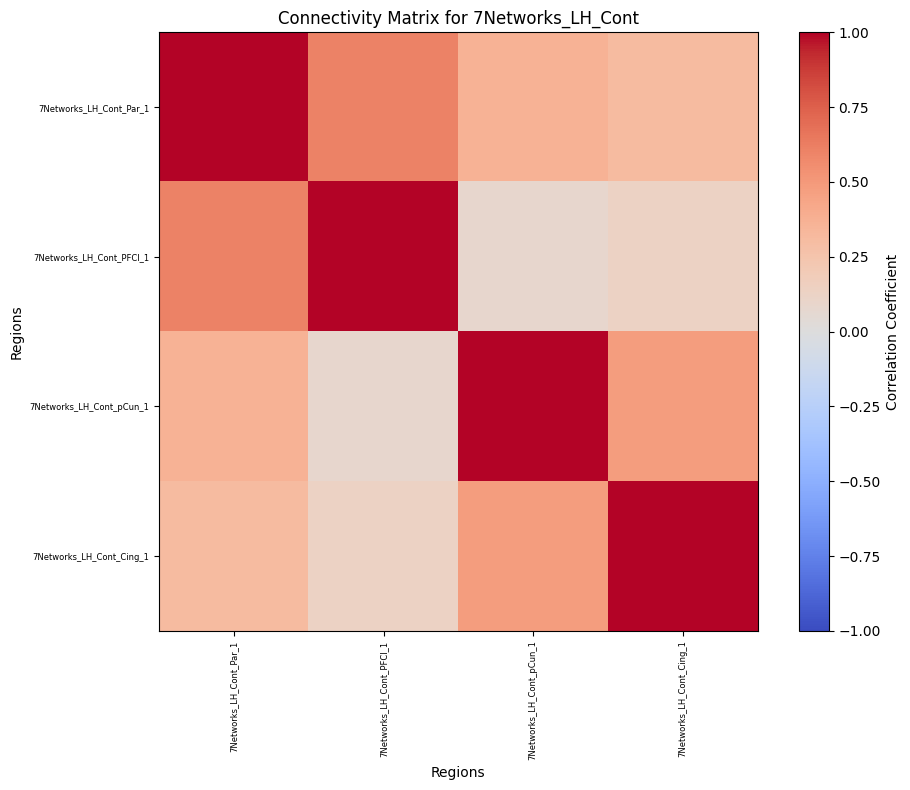

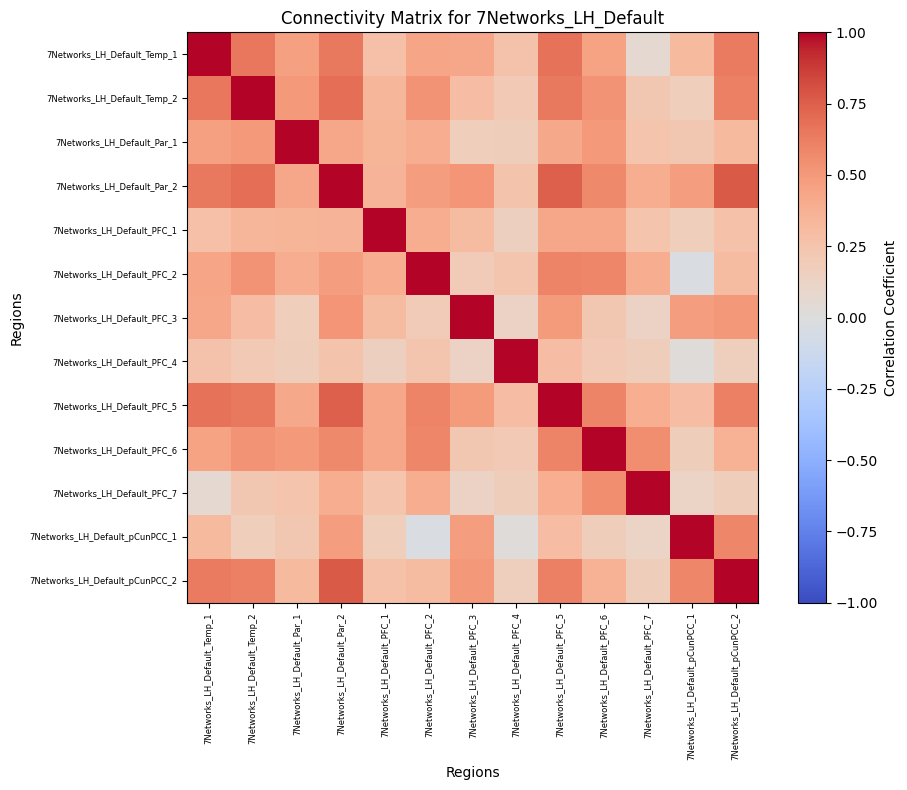

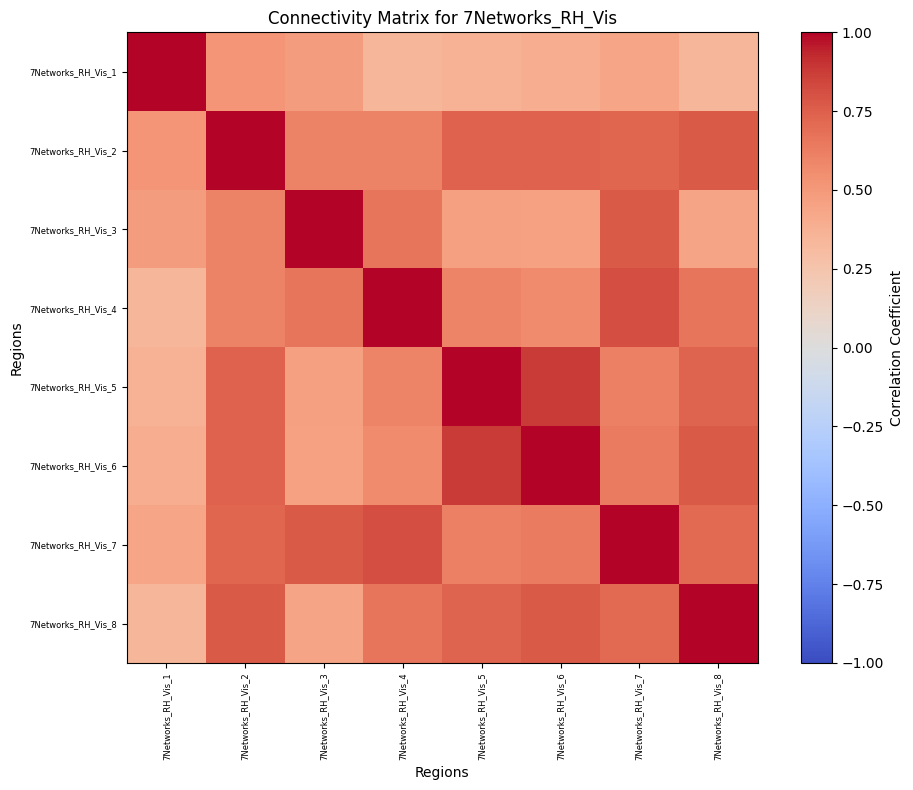

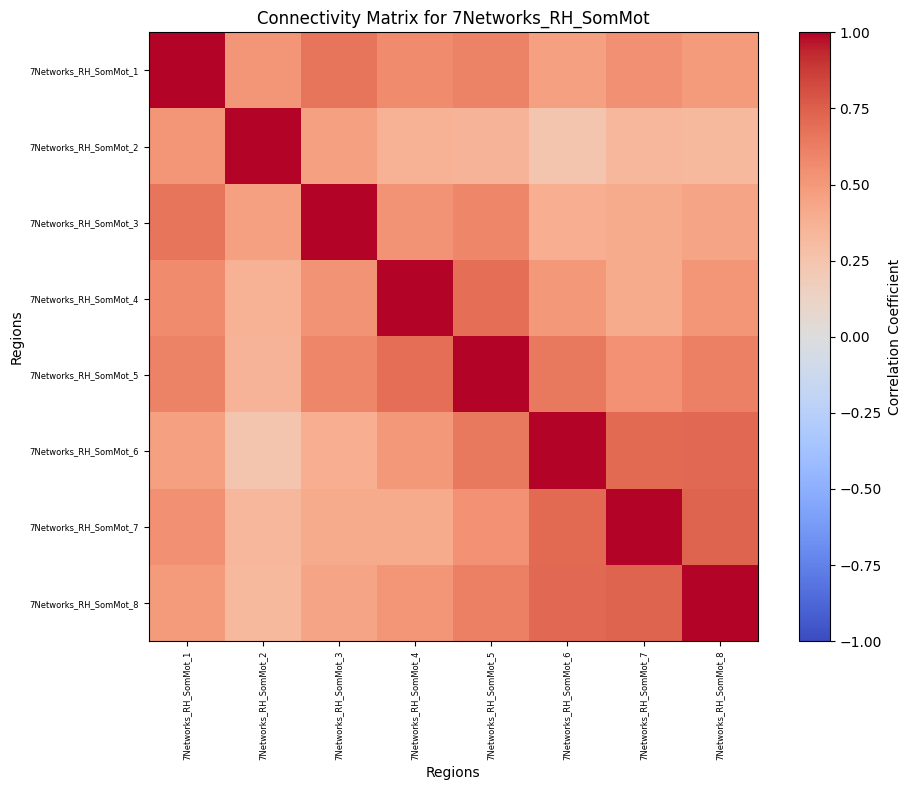

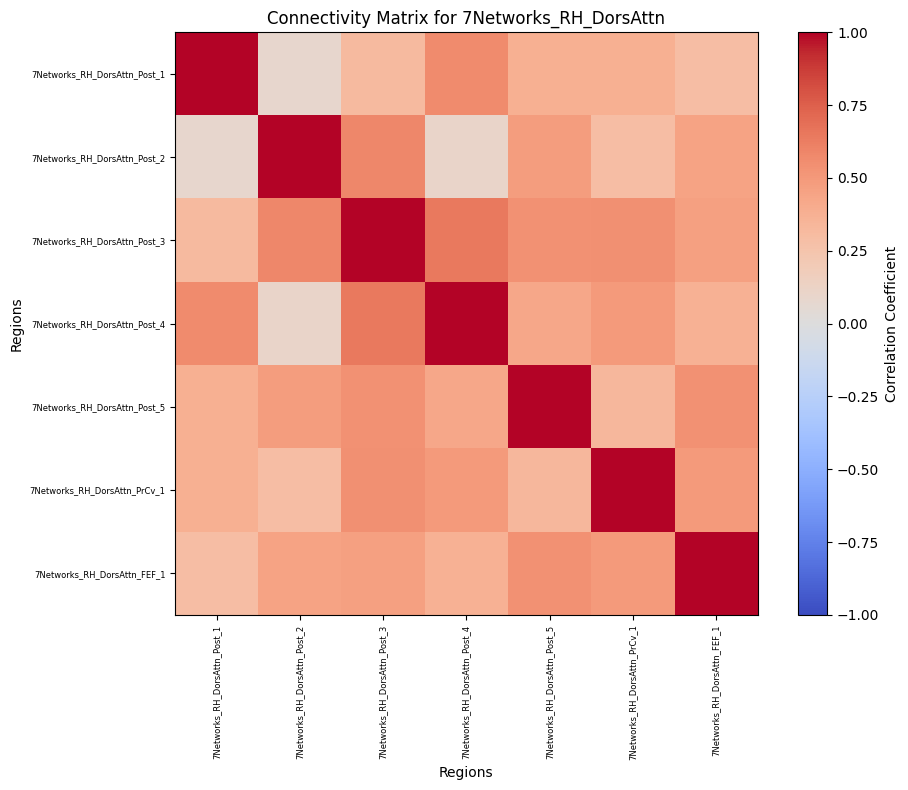

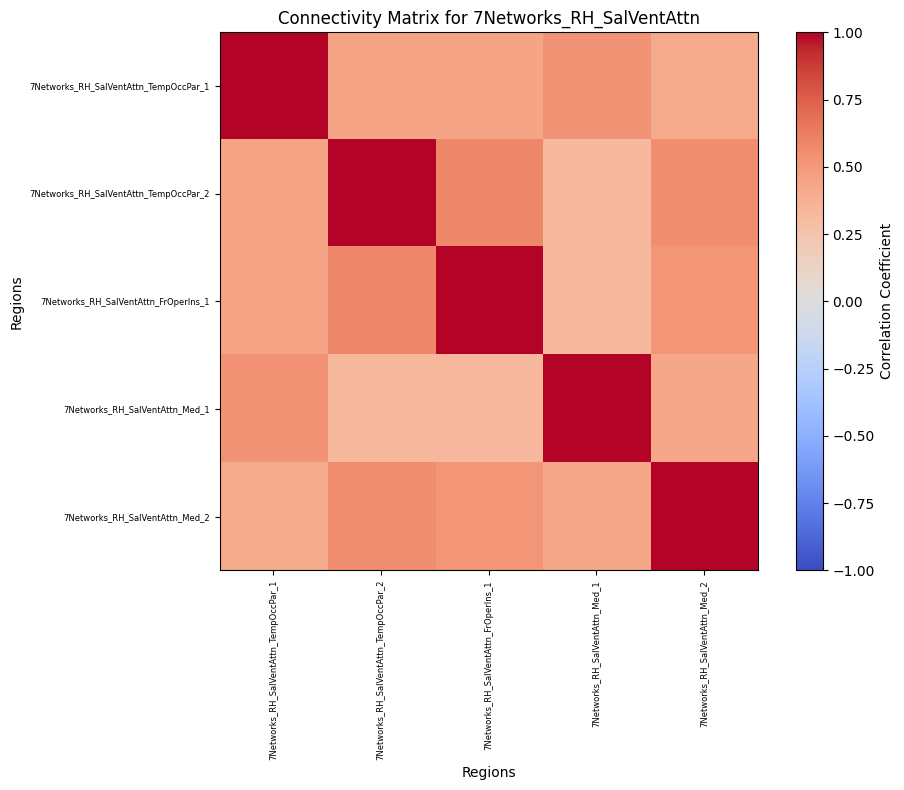

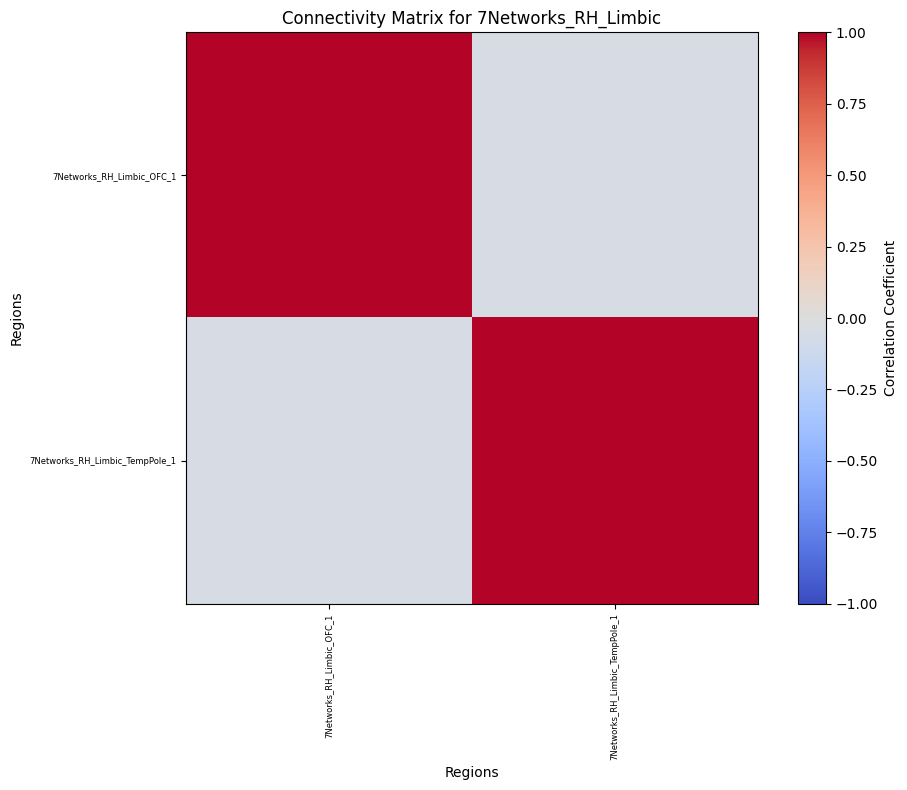

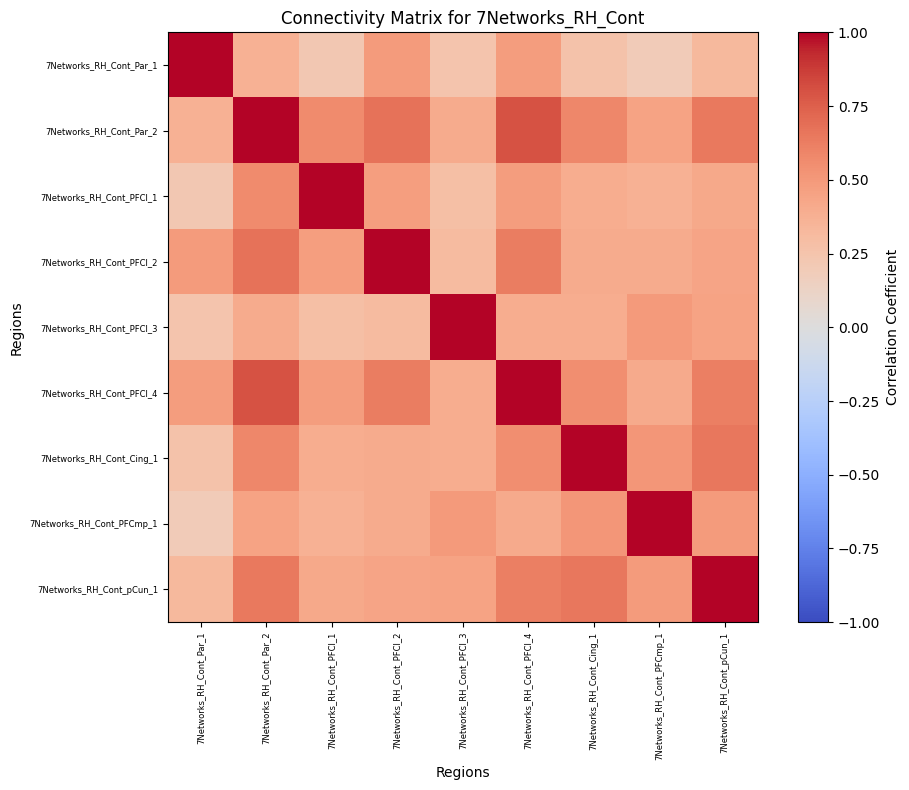

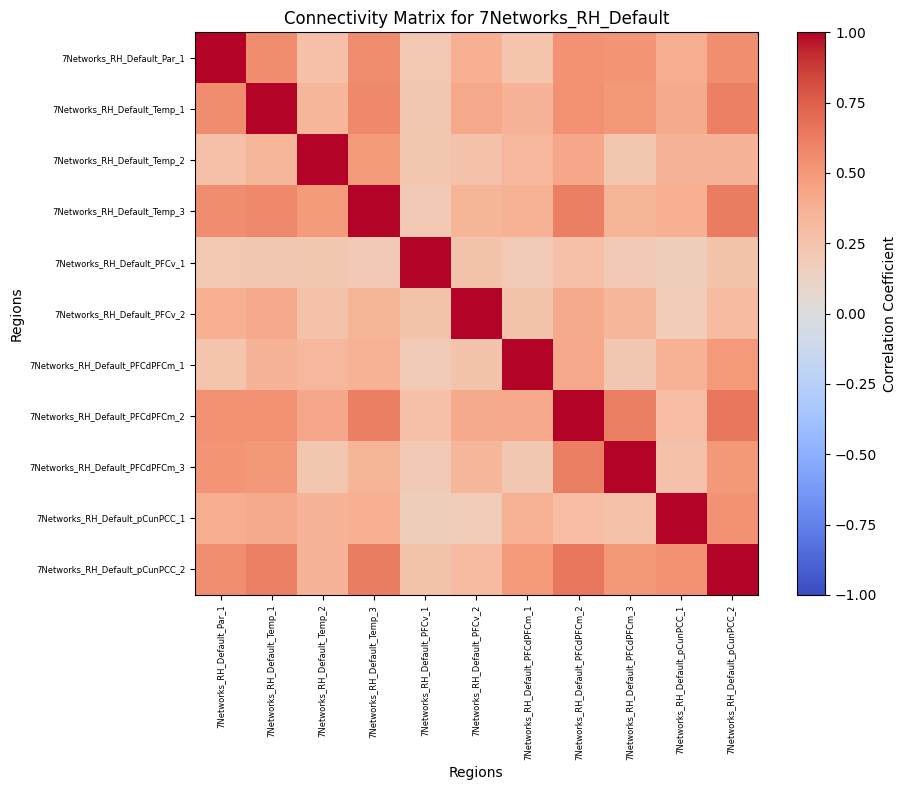

In [14]:
for network_to_analyze in network_prefixes:
    # Get the indices of the regions in the specified network
    region_indices = network_indices[network_to_analyze]

    # Extract the time series for these regions
    network_time_series = time_series[:, region_indices]

    # Calculate the Pearson correlation matrix for the network's regions
    network_correlation_matrix = np.corrcoef(network_time_series.T)

    # Plot the network correlation matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(network_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.colorbar(label='Correlation Coefficient')
    plt.title(f'Connectivity Matrix for {network_to_analyze}')
    plt.xlabel('Regions')
    plt.ylabel('Regions')
    plt.xticks(ticks=np.arange(len(region_indices)), labels=[region_names[i] for i in region_indices], rotation=90, fontsize=6)
    plt.yticks(ticks=np.arange(len(region_indices)), labels=[region_names[i] for i in region_indices], fontsize=6)
    plt.tight_layout()
    plt.savefig(f'Images/connectivity_matrix_{network_to_analyze}.png')
    plt.show()
